# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 1

In [2]:
cluster = '5'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 188
Num noneffect sequences: 188


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
106  chr19   45326535   45326536     rs344791      C         G   G      C   
64   chr17   45894775   45894776   rs11575896      G         A   G      A   
44   chr17   45718492   45718493  rs111985258      G         A   A      G   
167   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
84   chr19    1040765    1040766    rs4147904      A         G   A      G   
69   chr17   46071307   46071308   rs62060810      G         A   A    C,G   
52   chr17   45852871   45852872   rs79589869      C         A   C      A   
133   chr3   49007333   49007334    rs6781790      T         C   C      T   
62   chr17   45894418   45894419   rs11575895      G         A   A      G   
48   chr17   45740531   45740532   rs80157557      G         A   G      A   
184   chr7  100428668  100428669    rs3807475      A         G   G      A   
105  chr19   45326123   45326124     rs344792      A         G   G      A   
18   chr12   40224294   40224295    rs1388597      G         A   A      G   
110   chr2   95323523   95323524    rs3755519      T         A   A  C,G,T   
35   chr16   31117293   31117294    rs4889619      T         C   C    G,T   
78   chr17   75035094   75035095    rs7210163      A         G   G      A   
68   chr17   46051886   46051887   rs17575423      T         C   T      C   
71   chr17   46192692   46192693    rs2696633      T         A   A      T   
58   chr17   45876767   45876768   rs62055500      G         A   G      A   
156   chr4   89723356   89723357    rs8180214      G         A   G      A   
29   chr16   30922753   30922754    rs3813020      G         A   G      A   
144   chr4     987107     987108   rs11248061      C         A   C      A   
81   chr18   51197068   51197069    rs4396619      T         C   C      T   
26   chr16   28925937   28925938    rs4072402      T         C   T    A,C   
23   chr15   58749812   58749813     rs653765      C         T   T      C   
151   chr4   18022497   18022498    rs1380294      T         C   C      T   
109   chr2   95296799   95296800    rs3755525      G         C   C      G   
100  chr19   45001918   45001919   rs35194062      A         C   C      A   
31   chr16   30957267   30957268    rs4889599      T         C   C    G,T   
127   chr2  233172292  233172293    rs6431239      A         G   G      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
25   chr15   78944950   78944951    rs2289702      T         C   C      T   
175   chr7   23105294   23105295   rs10241208      C         G   G      C   
132   chr3   48998451   48998452    rs6414613      T         C   C      T   
140   chr3  161372827  161372828    rs2054710      T         C   C    G,T   
121   chr2  127107523  127107524   rs13032148      A         G   G      A   
162   chr4   89836142   89836143    rs1372518    NAN       NAN   A      C   
174   chr6   27762284   27762285    rs9295746      T         C   T      C   
171   chr5  103041308  103041309    rs6881612      T         C   C      T   
187   chr8   27479527   27479528   rs35505579      T         A   A      T   
112   chr2  127084192  127084193   rs10200967      T         C   C      T   
12   chr11   86068254   86068255    rs2509608      T         G   T    C,G   
43   chr17   45664085   45664086   rs17760577      T         C   C      T   
1     chr1  171742011  171742012   rs12119232      C         A   A      C   
141   chr4     973550     973551  rs113075206      G         C   C      G   
142   chr4     973656     973657   rs13137144      G         A   G    A,C   
122   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
126   chr2  168247488  168247489   rs76179989      T         G   T      G   
157   chr4   89753279   89753280     rs356168      A         G   G      A   
186   chr8   22623005   22623006   rs11780207      G         A   G      A   
160   chr4   89808595   89808596    rs2619368      T         G   T      G   
152

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 106   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1672   ||   Center / 200bp : 0.3327
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


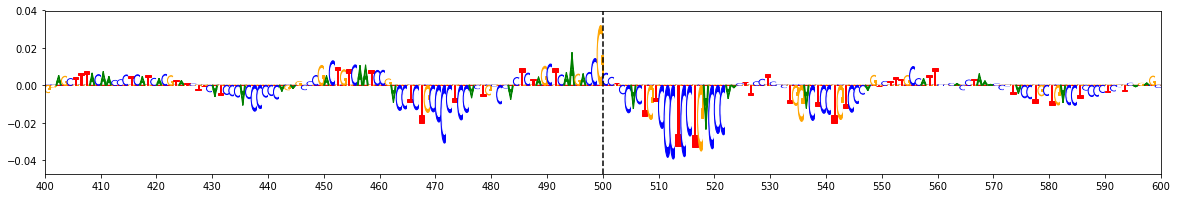

Effect Allele : C   ||   Explain Score : 0.0331   ||   Center / 200bp : 0.0907
Effect Sequence : CTCAAGACCCCCTCCACTGT


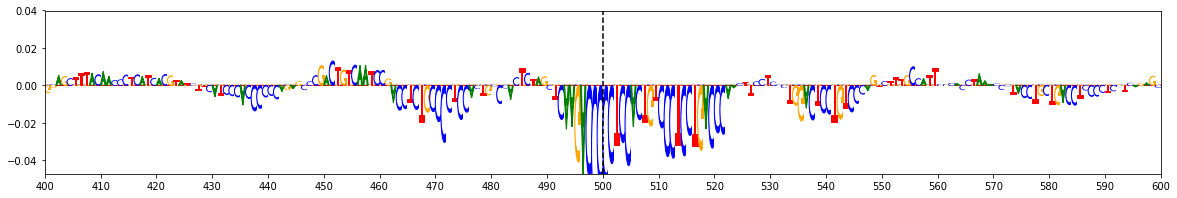

Allele Ratio : 0.1978   ||   Allele Difference : -0.6692  ||  ISM Score : -1.0754  ||  deltaSVM Score : -6.2029


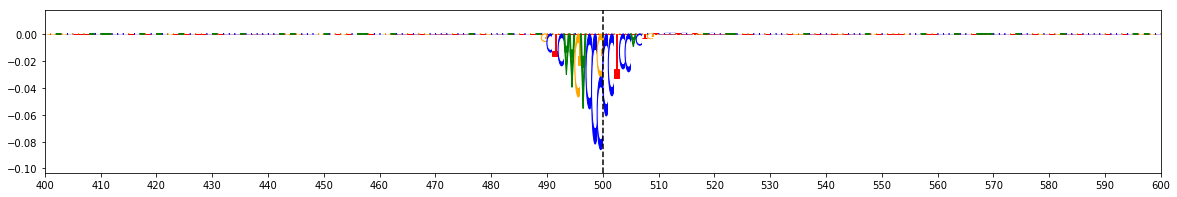


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 64   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6061   ||   Center / 200bp : 0.6566
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


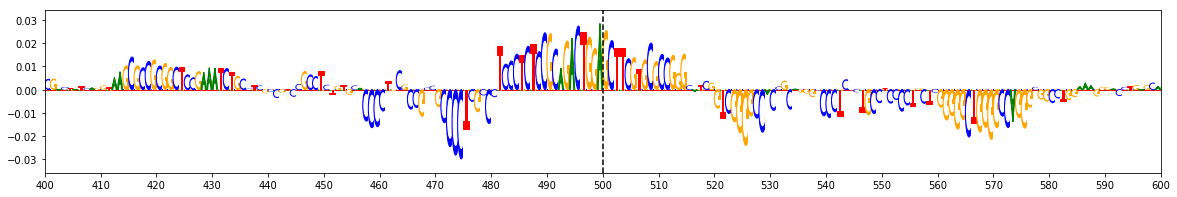

Effect Allele : G   ||   Explain Score : 0.3392   ||   Center / 200bp : 0.5171
Effect Sequence : GCAGACTGGGGCTTCGTGCG


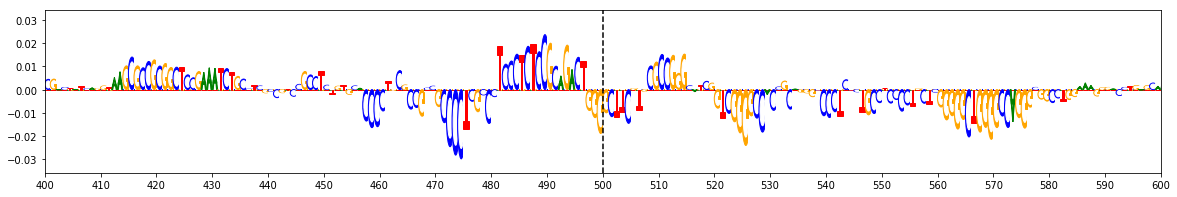

Allele Ratio : 0.5596   ||   Allele Difference : -0.3742  ||  ISM Score : -0.6011  ||  deltaSVM Score : -3.4447


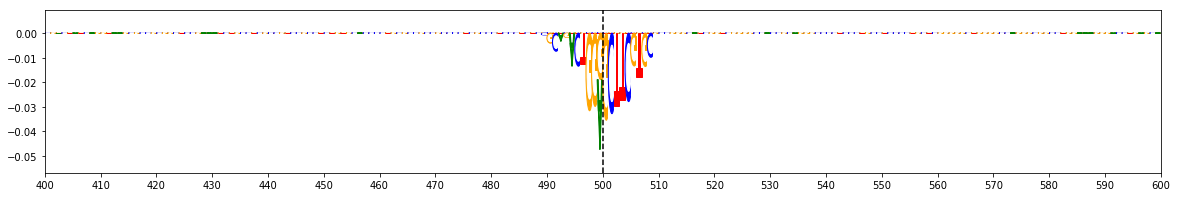


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs111985258   ||    chr17 : 45718492 - 45718493   ||    Locus: 44   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.71E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6607   ||   Center / 200bp : 0.7715
Noneffect Sequence : GGACTACAGACAGTGCCACC


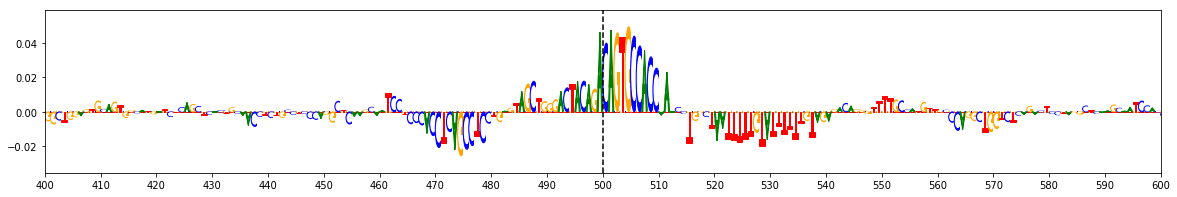

Effect Allele : G   ||   Explain Score : 0.4689   ||   Center / 200bp : 0.7056
Effect Sequence : GGACTACAGGCAGTGCCACC


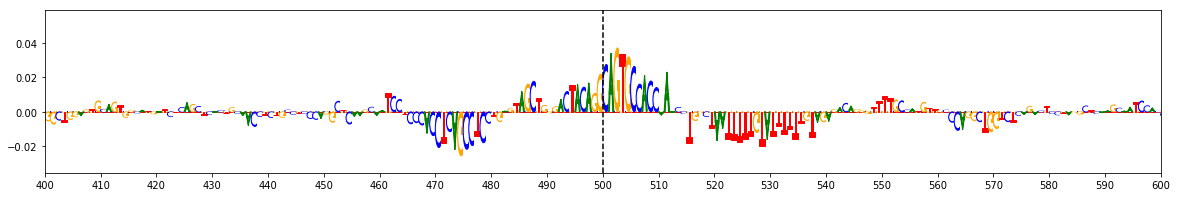

Allele Ratio : 0.7097   ||   Allele Difference : -0.1923  ||  ISM Score : -0.3173  ||  deltaSVM Score : -1.8691


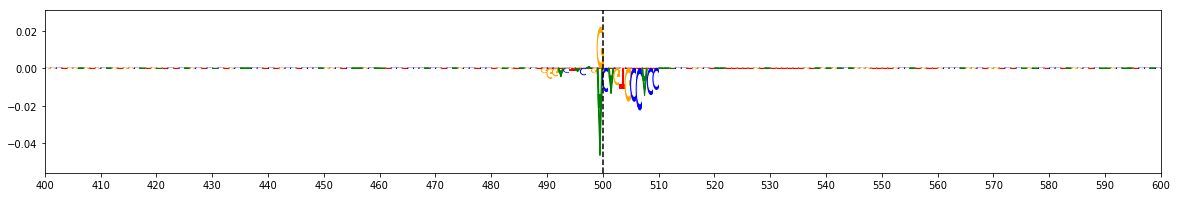


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 167   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.2522   ||   Center / 200bp : 0.5646
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


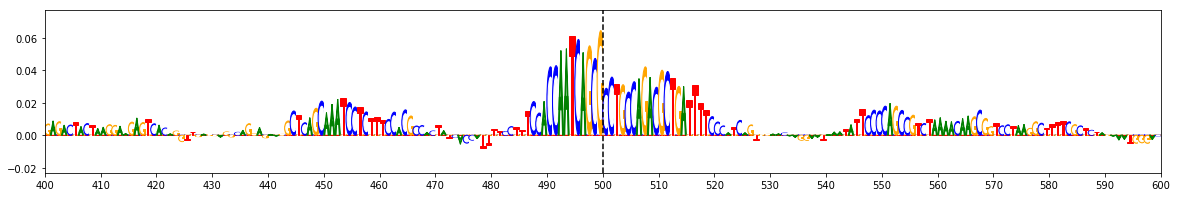

Effect Allele : NAN   ||   Explain Score : 0.6849   ||   Center / 200bp : 0.4131
Effect Sequence : CCAATCAGCCCCTGCCAGAC


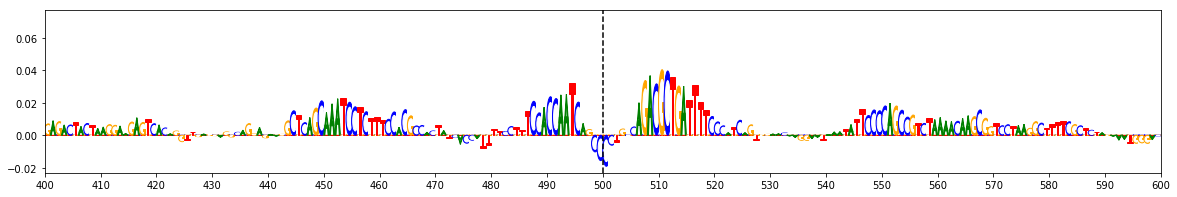

Allele Ratio : 0.547   ||   Allele Difference : -0.6226  ||  ISM Score : -0.9457  ||  deltaSVM Score : -5.7074


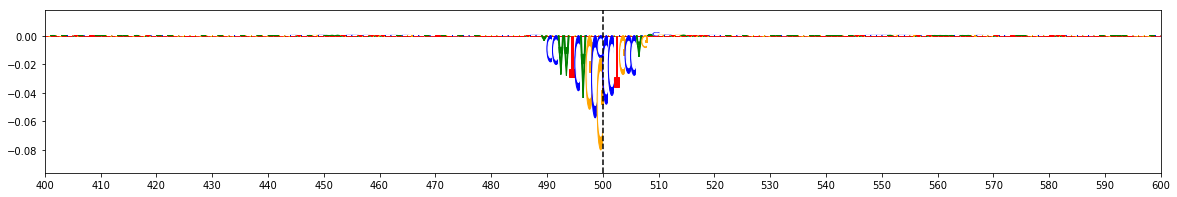


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4147904   ||    chr19 : 1040765 - 1040766   ||    Locus: 84   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.01E-08

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.7999   ||   Center / 200bp : 0.5816
Noneffect Sequence : CGTGCCTCCGGCTGGGCAAC


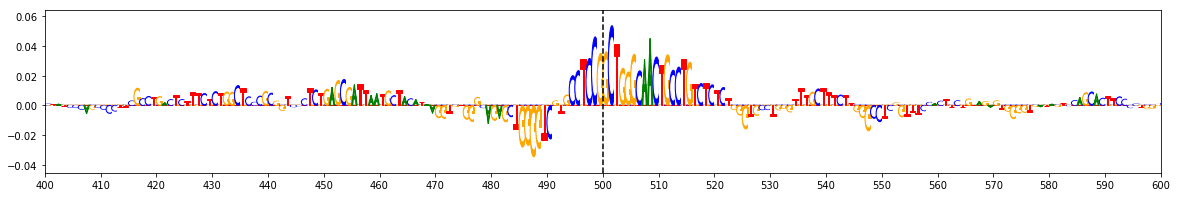

Effect Allele : A   ||   Explain Score : 0.4784   ||   Center / 200bp : 0.4542
Effect Sequence : CGTGCCTCCAGCTGGGCAAC


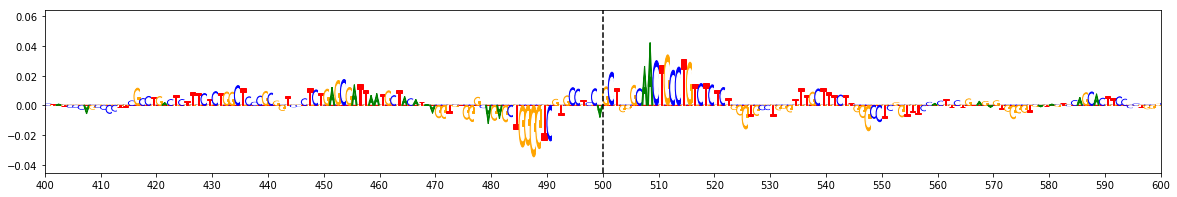

Allele Ratio : 0.598   ||   Allele Difference : -0.3388  ||  ISM Score : -0.5317  ||  deltaSVM Score : -3.0196


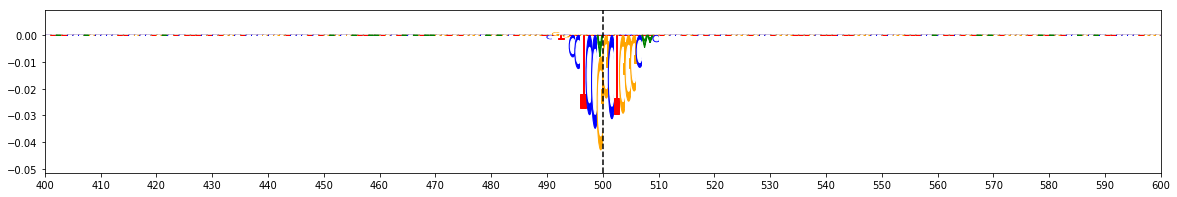


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62060810   ||    chr17 : 46071307 - 46071308   ||    Locus: 69   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.53E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8452   ||   Center / 200bp : 0.7357
Noneffect Sequence : ACAAAAAAGAAAGCACTGGA


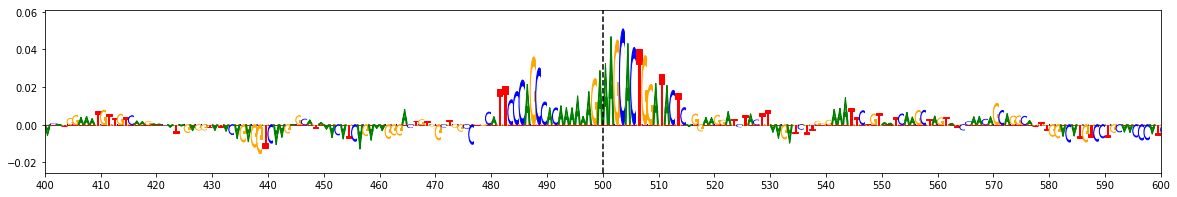

Effect Allele : G   ||   Explain Score : 0.671   ||   Center / 200bp : 0.6885
Effect Sequence : ACAAAAAAGGAAGCACTGGA


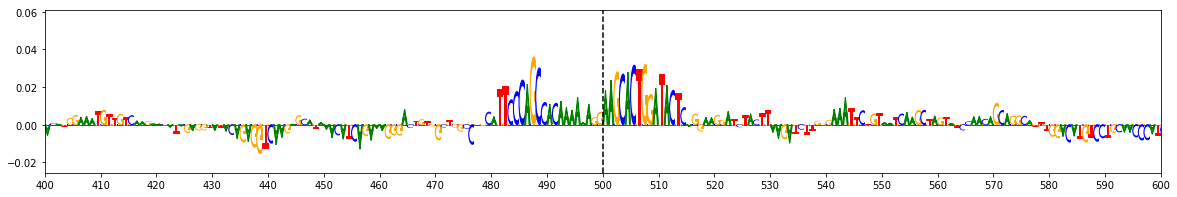

Allele Ratio : 0.7939   ||   Allele Difference : -0.1742  ||  ISM Score : -0.2723  ||  deltaSVM Score : -1.5417


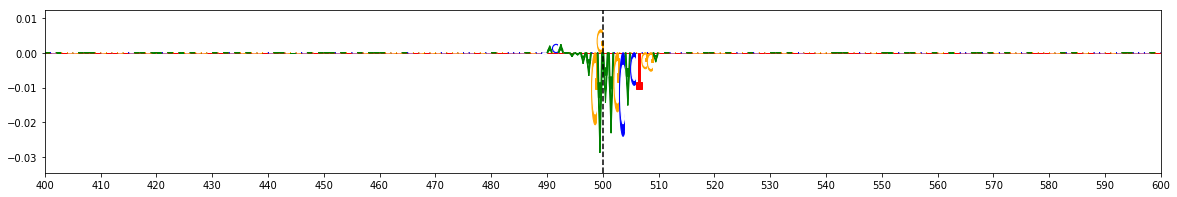


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 52   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.6055   ||   Center / 200bp : 0.8451
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


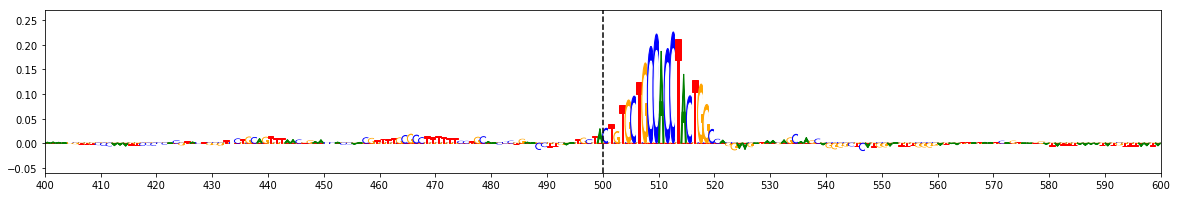

Effect Allele : C   ||   Explain Score : 2.412   ||   Center / 200bp : 0.8347
Effect Sequence : TTGAATGCTCCTGTGCTGCC


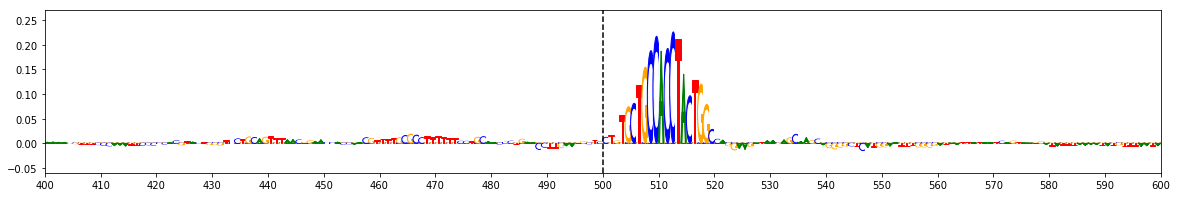

Allele Ratio : 0.9257   ||   Allele Difference : -0.2159  ||  ISM Score : -0.3383  ||  deltaSVM Score : -1.9607


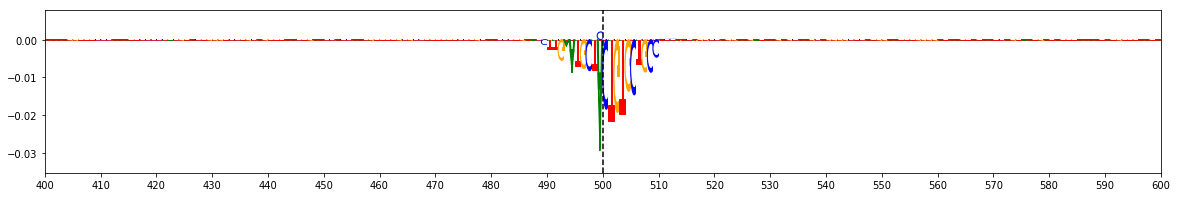


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 133   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0951   ||   Center / 200bp : 0.4818
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


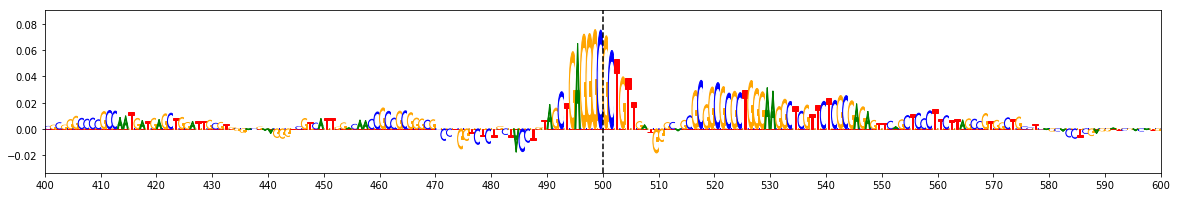

Effect Allele : T   ||   Explain Score : 0.5916   ||   Center / 200bp : 0.3341
Effect Sequence : AGCTGAGGGTGCTGTTGATG


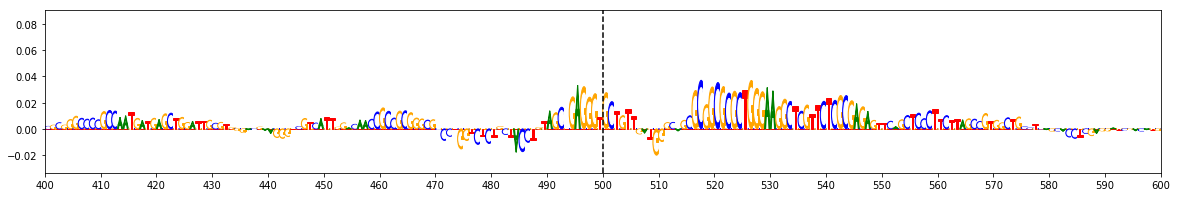

Allele Ratio : 0.5402   ||   Allele Difference : -0.5174  ||  ISM Score : -0.8152  ||  deltaSVM Score : -4.7088


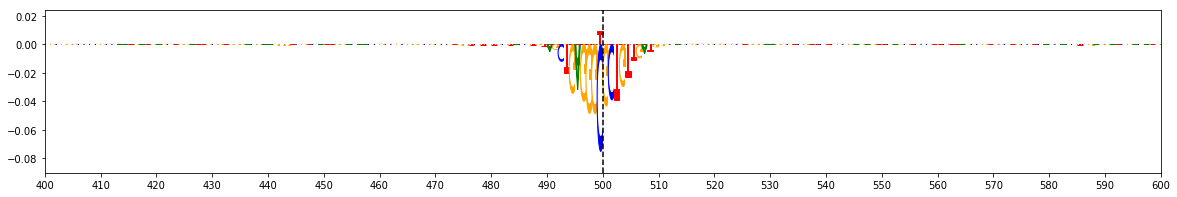


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 62   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.2515   ||   Center / 200bp : 0.6525
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


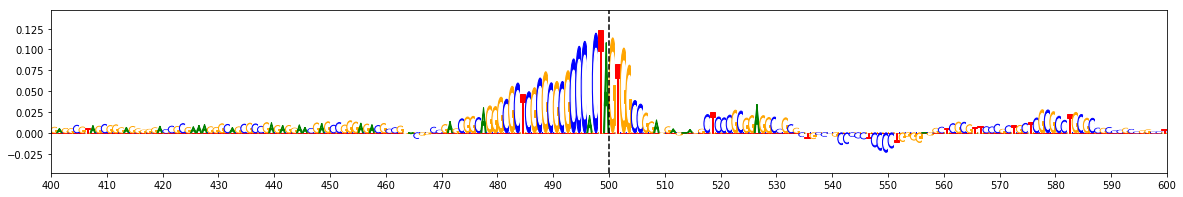

Effect Allele : G   ||   Explain Score : 1.8871   ||   Center / 200bp : 0.6093
Effect Sequence : GCGCCCACTGGTGGCCGGAG


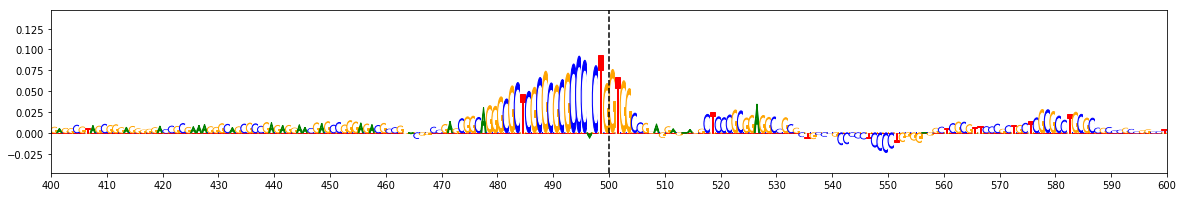

Allele Ratio : 0.8382   ||   Allele Difference : -0.3757  ||  ISM Score : -0.5558  ||  deltaSVM Score : -3.7518


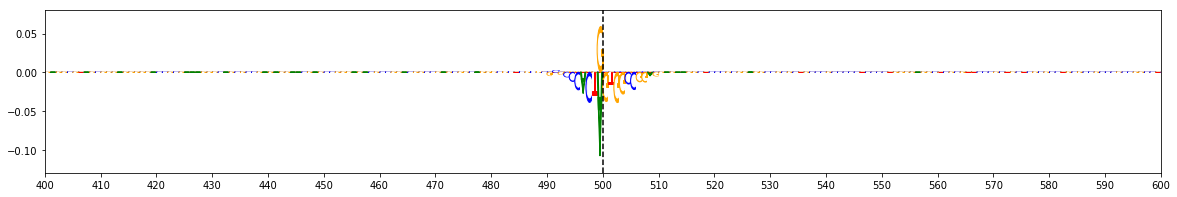


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80157557   ||    chr17 : 45740531 - 45740532   ||    Locus: 48   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.91E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.939   ||   Center / 200bp : 0.5413
Noneffect Sequence : CTGTGTAACAGGCTCCAGCC


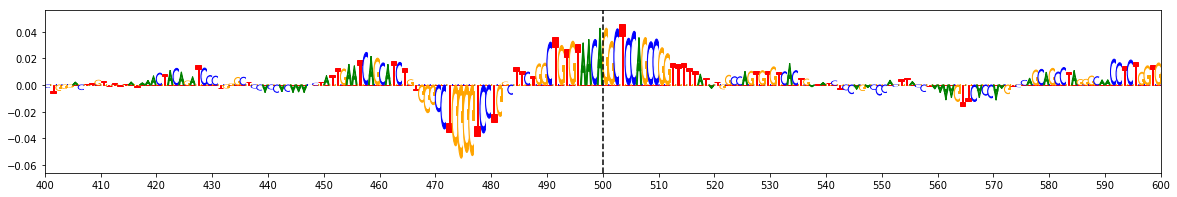

Effect Allele : G   ||   Explain Score : 0.6542   ||   Center / 200bp : 0.4513
Effect Sequence : CTGTGTAACGGGCTCCAGCC


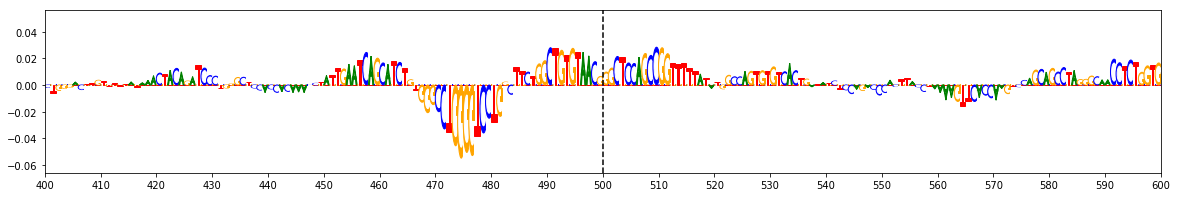

Allele Ratio : 0.6967   ||   Allele Difference : -0.2847  ||  ISM Score : -0.4451  ||  deltaSVM Score : -2.5662


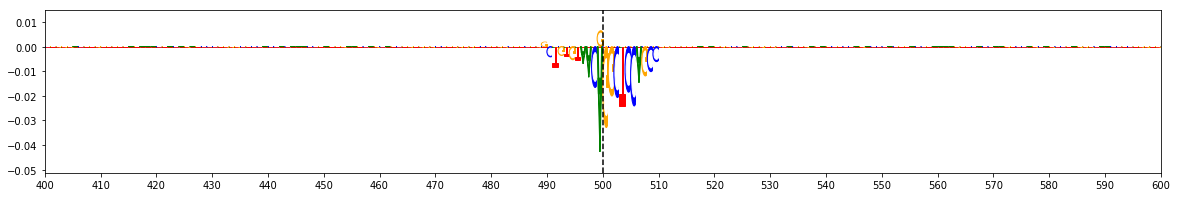


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3807475   ||    chr7 : 100428668 - 100428669   ||    Locus: 184   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.18E-07

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.1926   ||   Center / 200bp : 0.6038
Noneffect Sequence : ATCTCCCCGGGAAAACGGCG


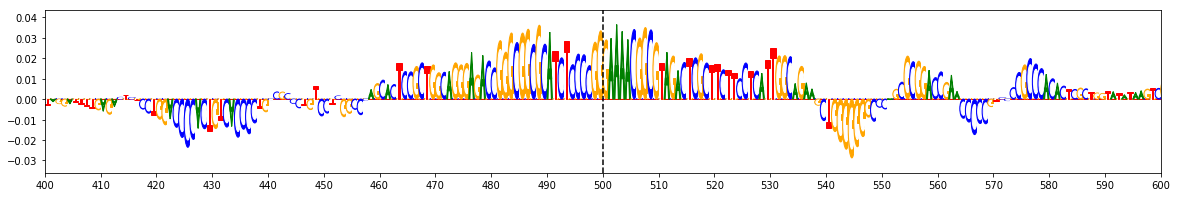

Effect Allele : A   ||   Explain Score : 0.928   ||   Center / 200bp : 0.542
Effect Sequence : ATCTCCCCGAGAAAACGGCG


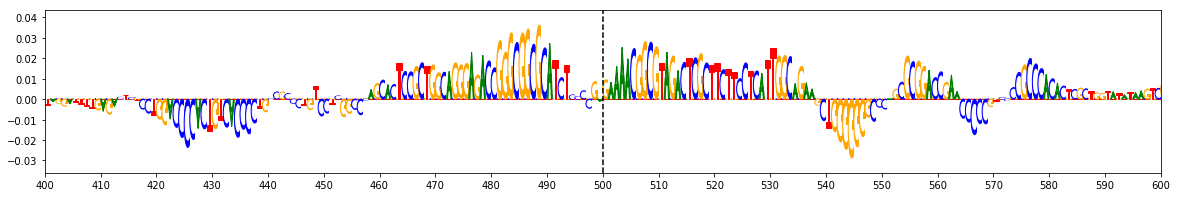

Allele Ratio : 0.7781   ||   Allele Difference : -0.2703  ||  ISM Score : -0.4218  ||  deltaSVM Score : -2.4786


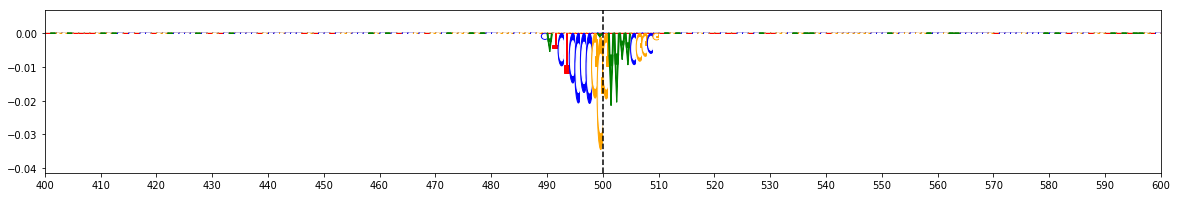


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344792   ||    chr19 : 45326123 - 45326124   ||    Locus: 105   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.52E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1509   ||   Center / 200bp : 0.3902
Noneffect Sequence : CTAGTCTCAGACTCCTACCT


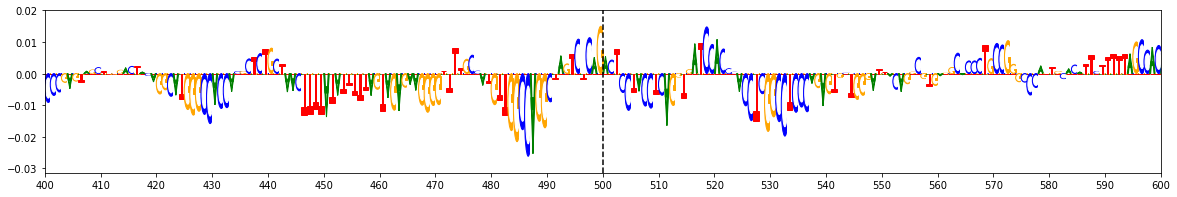

Effect Allele : A   ||   Explain Score : 0.0763   ||   Center / 200bp : 0.244
Effect Sequence : CTAGTCTCAAACTCCTACCT


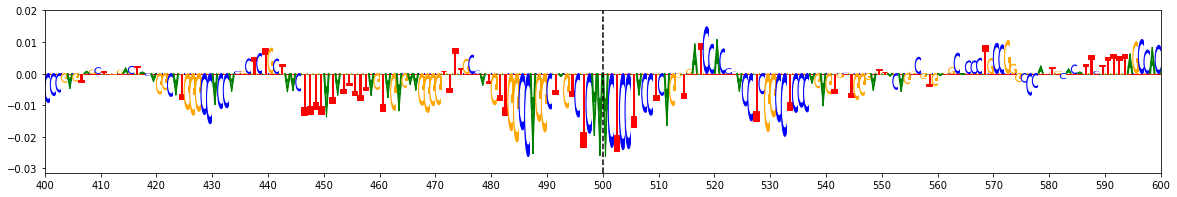

Allele Ratio : 0.5059   ||   Allele Difference : -0.325  ||  ISM Score : -0.5149  ||  deltaSVM Score : -2.8985


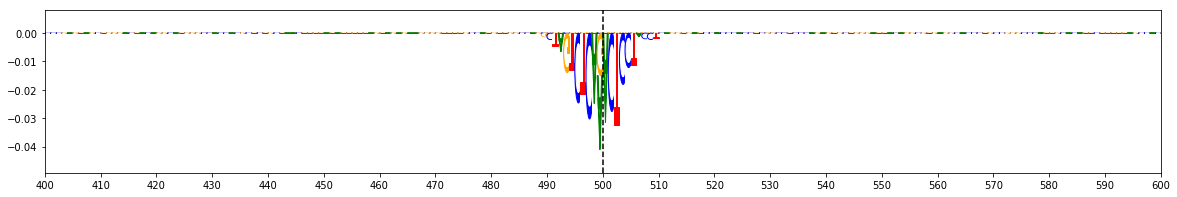


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1388597   ||    chr12 : 40224294 - 40224295   ||    Locus: 18   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.37E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.7287   ||   Center / 200bp : 0.6448
Noneffect Sequence : CTCACAGGGAAACAATGTTT


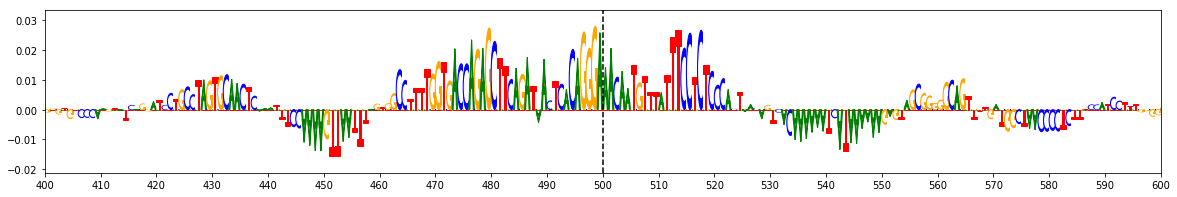

Effect Allele : G   ||   Explain Score : 0.6135   ||   Center / 200bp : 0.604
Effect Sequence : CTCACAGGGGAACAATGTTT


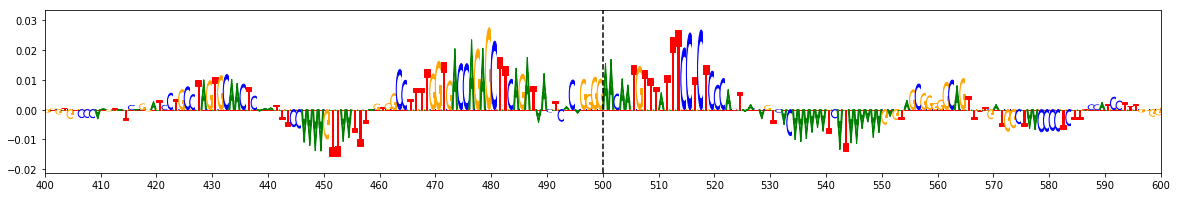

Allele Ratio : 0.8419   ||   Allele Difference : -0.1211  ||  ISM Score : -0.1861  ||  deltaSVM Score : -1.1132


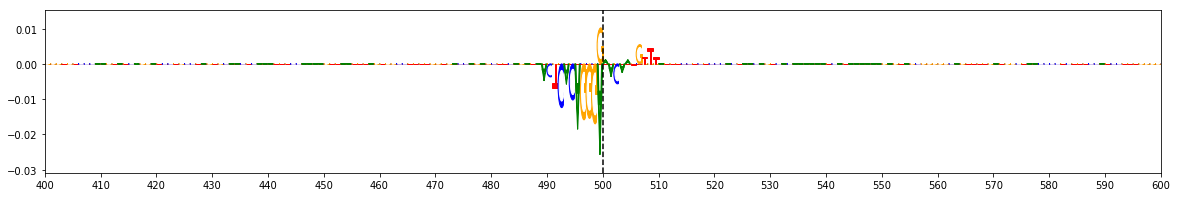


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3755519   ||    chr2 : 95323523 - 95323524   ||    Locus: 110   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  7.68E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.0178   ||   Center / 200bp : 0.4392
Noneffect Sequence : GGGTGCAGGAGTGCTCTCTG


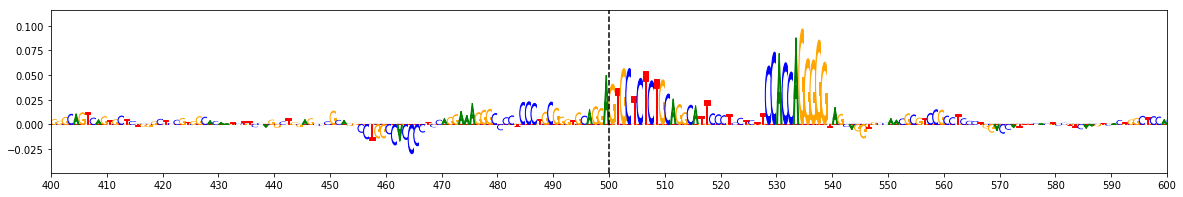

Effect Allele : T   ||   Explain Score : 0.6035   ||   Center / 200bp : 0.3168
Effect Sequence : GGGTGCAGGTGTGCTCTCTG


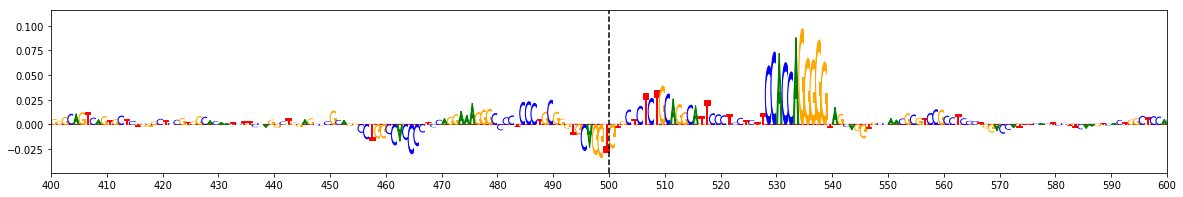

Allele Ratio : 0.5929   ||   Allele Difference : -0.6057  ||  ISM Score : -0.9539  ||  deltaSVM Score : -5.4874


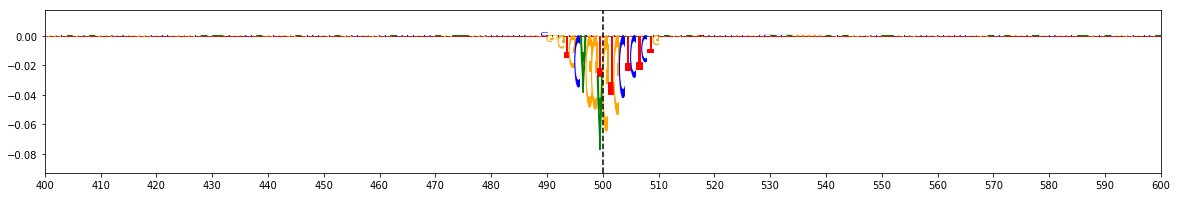


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4889619   ||    chr16 : 31117293 - 31117294   ||    Locus: 35   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.40E-02

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.5614   ||   Center / 200bp : 0.4592
Noneffect Sequence : GCTTGAACCCGGAGGCGGAG


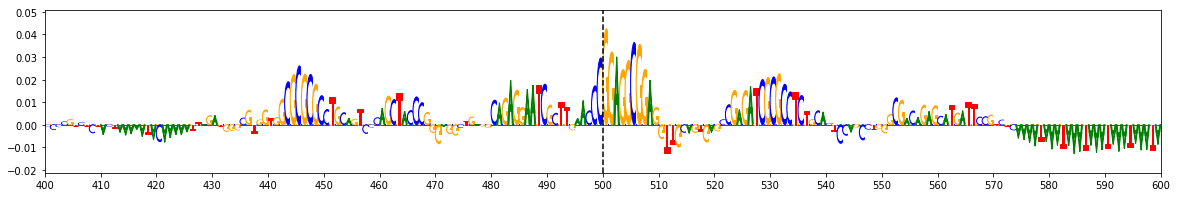

Effect Allele : T   ||   Explain Score : 0.3511   ||   Center / 200bp : 0.3467
Effect Sequence : GCTTGAACCTGGAGGCGGAG


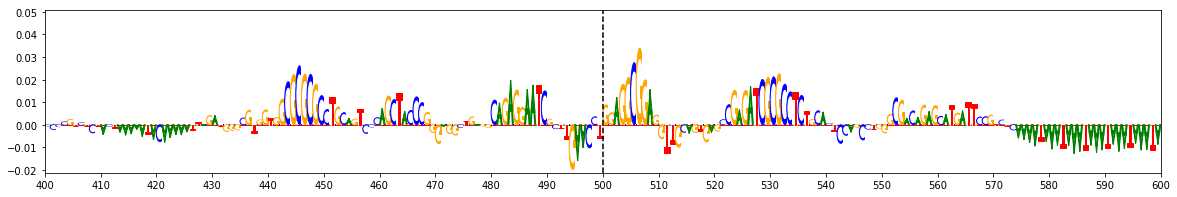

Allele Ratio : 0.6254   ||   Allele Difference : -0.2801  ||  ISM Score : -0.4728  ||  deltaSVM Score : -2.7444


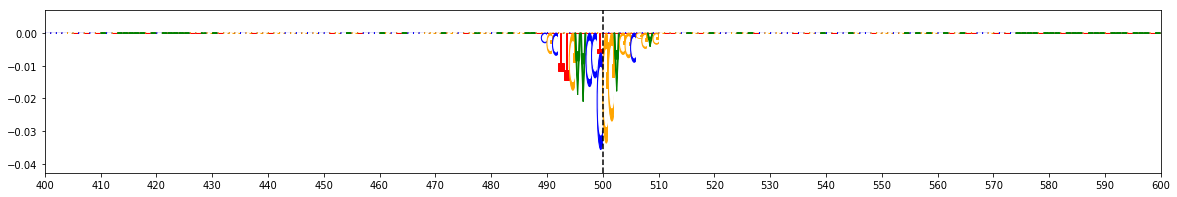


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7210163   ||    chr17 : 75035094 - 75035095   ||    Locus: 78   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.08E-05
Alzheimers_Lambert_2013 	  1.54E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.9104   ||   Center / 200bp : 0.4912
Noneffect Sequence : CCTCTCTAGGAGGTAGCTGC


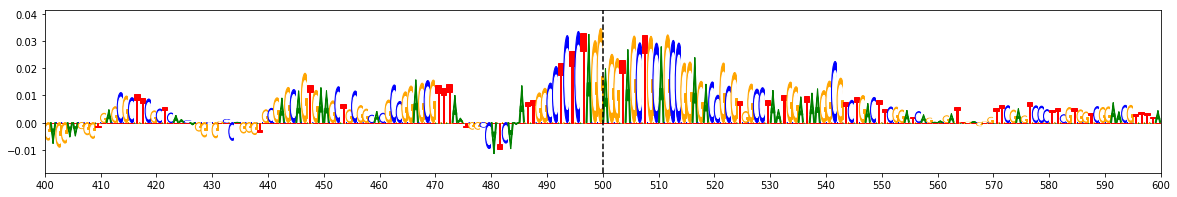

Effect Allele : A   ||   Explain Score : 0.6202   ||   Center / 200bp : 0.3967
Effect Sequence : CCTCTCTAGAAGGTAGCTGC


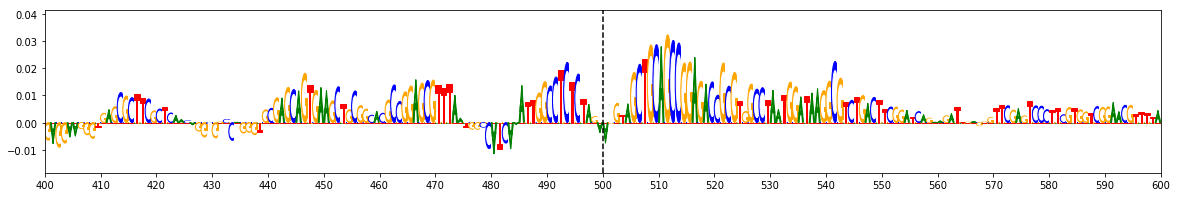

Allele Ratio : 0.6812   ||   Allele Difference : -0.3017  ||  ISM Score : -0.4768  ||  deltaSVM Score : -2.7261


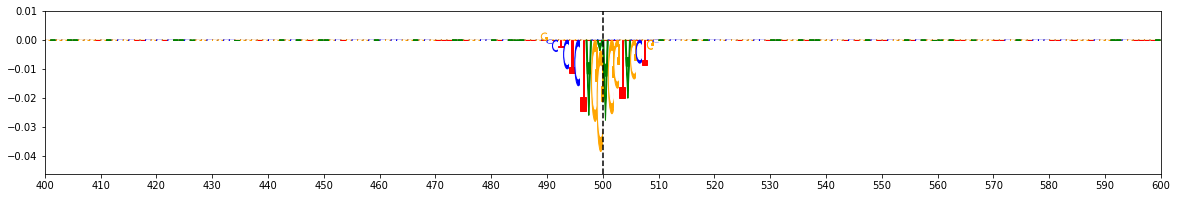


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17575423   ||    chr17 : 46051886 - 46051887   ||    Locus: 68   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.44E-10

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4019   ||   Center / 200bp : 0.4009
Noneffect Sequence : ATTCTATTGCAACCACATAG


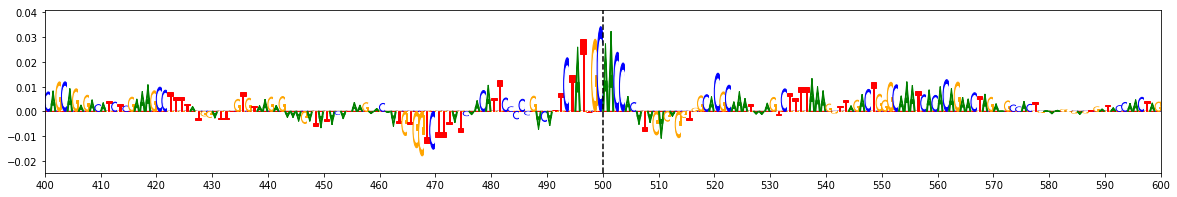

Effect Allele : T   ||   Explain Score : 0.2274   ||   Center / 200bp : 0.2747
Effect Sequence : ATTCTATTGTAACCACATAG


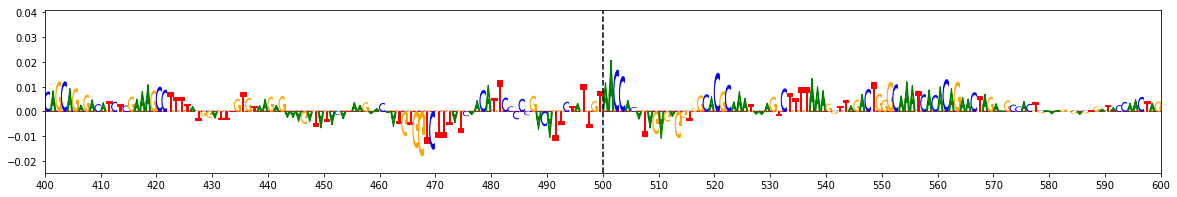

Allele Ratio : 0.5659   ||   Allele Difference : -0.2055  ||  ISM Score : -0.3203  ||  deltaSVM Score : -1.8697


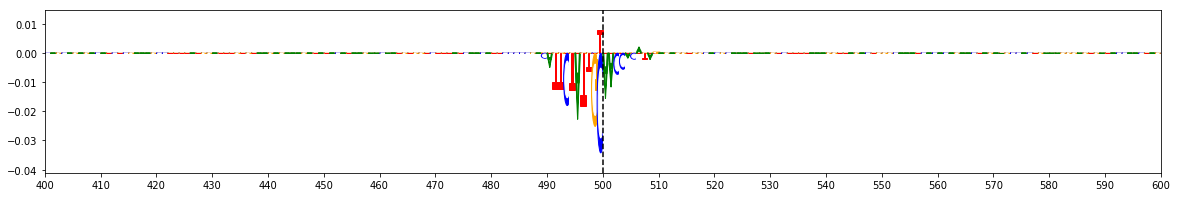


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2696633   ||    chr17 : 46192692 - 46192693   ||    Locus: 71   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.65E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.5229   ||   Center / 200bp : 0.4821
Noneffect Sequence : TTCCGGGGGATTTTTCTACC


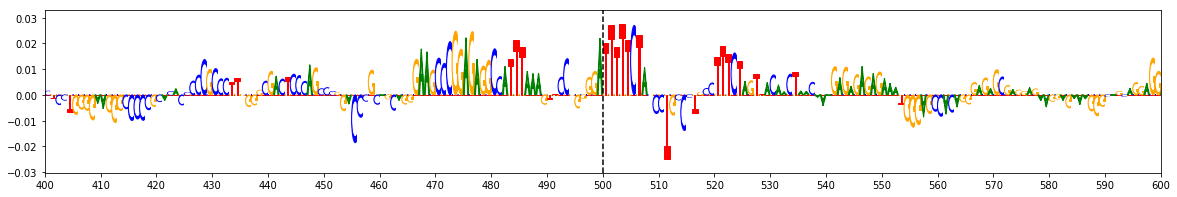

Effect Allele : T   ||   Explain Score : 0.3714   ||   Center / 200bp : 0.3986
Effect Sequence : TTCCGGGGGTTTTTTCTACC


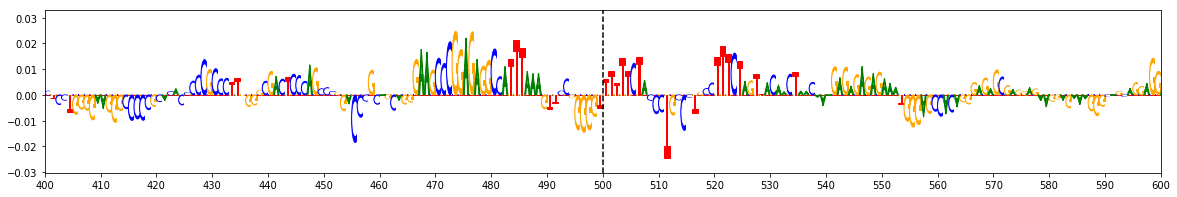

Allele Ratio : 0.7103   ||   Allele Difference : -0.212  ||  ISM Score : -0.3348  ||  deltaSVM Score : -1.934


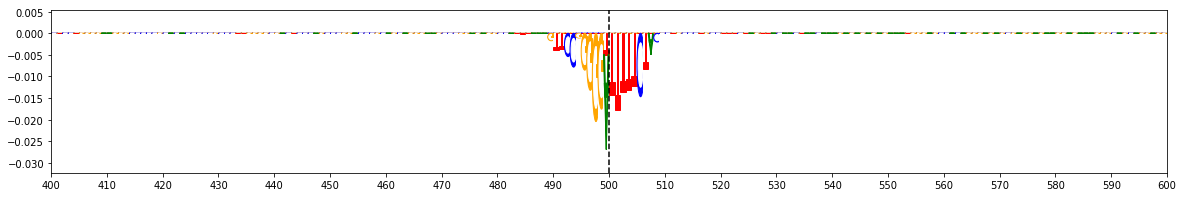


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62055500   ||    chr17 : 45876767 - 45876768   ||    Locus: 58   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.79E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8428   ||   Center / 200bp : 0.5986
Noneffect Sequence : CTGAGTCATAGGTAACTCAA


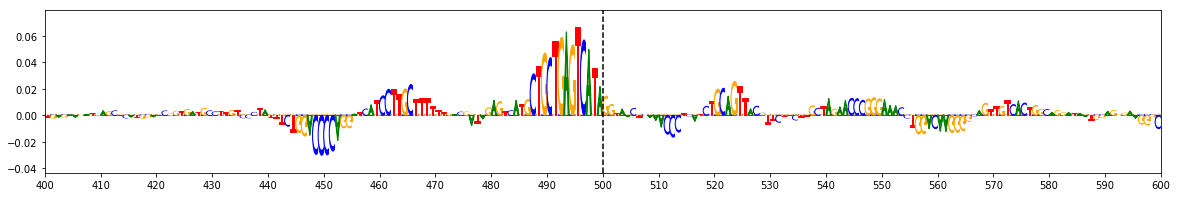

Effect Allele : G   ||   Explain Score : 0.7501   ||   Center / 200bp : 0.5701
Effect Sequence : CTGAGTCATGGGTAACTCAA


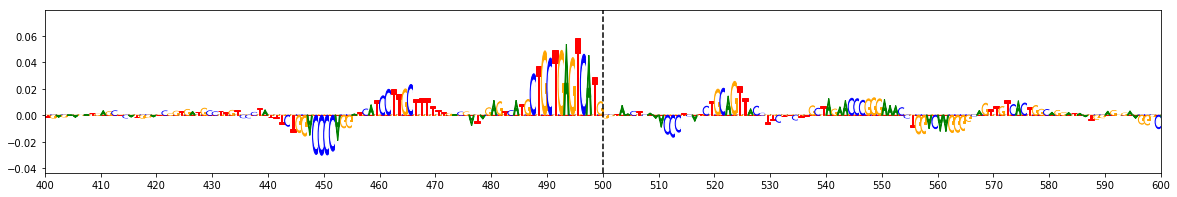

Allele Ratio : 0.8899   ||   Allele Difference : -0.0897  ||  ISM Score : -0.1412  ||  deltaSVM Score : -0.8172


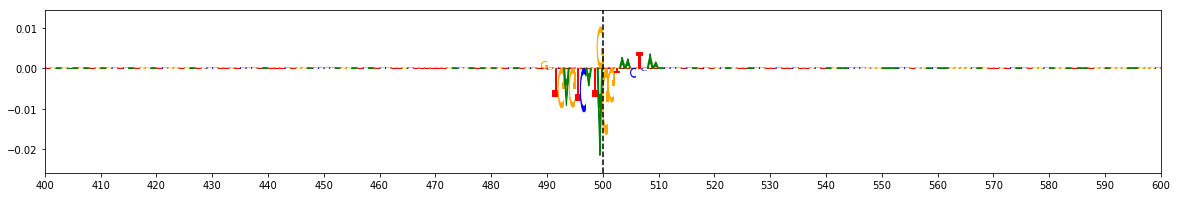


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8180214   ||    chr4 : 89723356 - 89723357   ||    Locus: 156   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.06E-18

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.4249   ||   Center / 200bp : 0.5747
Noneffect Sequence : ATTCAAATCAGACACTATCT


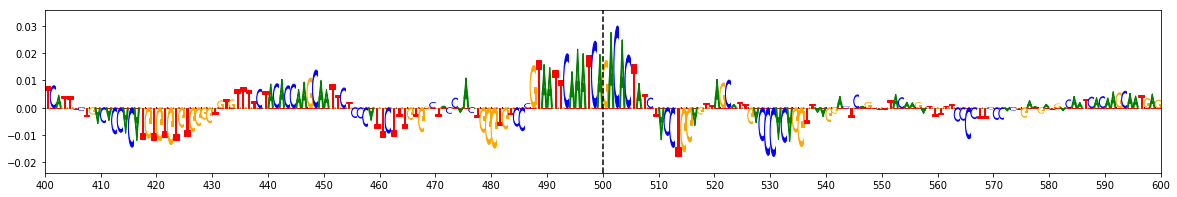

Effect Allele : G   ||   Explain Score : 0.3661   ||   Center / 200bp : 0.5378
Effect Sequence : ATTCAAATCGGACACTATCT


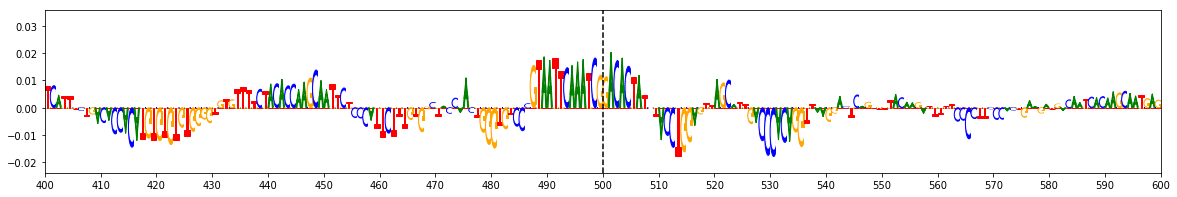

Allele Ratio : 0.8615   ||   Allele Difference : -0.0592  ||  ISM Score : -0.0926  ||  deltaSVM Score : -0.5163


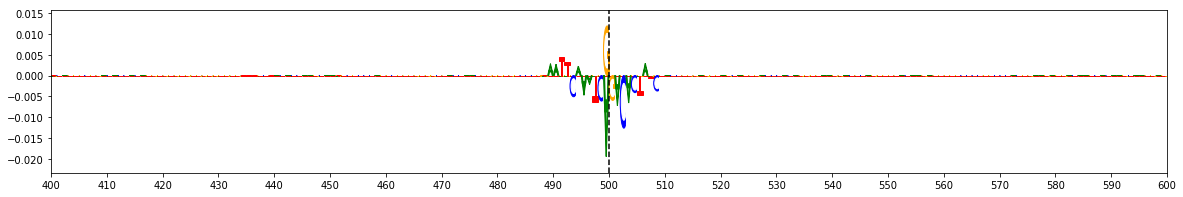


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
101  chr19   45039212   45039213   rs34034621      T         C   C      T   
57   chr17   45876624   45876625   rs62055499      G         C   C      G   
153   chr4   89723193   89723194   rs79596632      G         A   G      A   
87   chr19   44644039   44644040   rs11540084      T         G   G      T   
8    chr11   47415851   47415852    rs2293578      T         C   C      T   
30   chr16   30941880   30941881    rs1458202      G         A   G    A,C   
154   chr4   89723238   89723239   rs74329237      G         A   G      A   
40   chr17    5282069    5282070  rs113151753      G         C   C    G,T   
54   chr17   45861267   45861268   rs62054846      G         A   A      G   
147   chr4   17949002   17949003   rs16896101      G         A   A      G   
155   chr4   89723302   89723303    rs8180209      G         A   A      G   
14   chr11   86069405   86069406    rs3016327      T         C   T      C   
182   chr7  100226729  100226730    rs1859787      G         A   G      A   
107   chr2   95076932   95076933    rs3105101      C         A   C      A   
66   chr17   46002354   46002355   rs62064662      G         A   A      G   
137   chr3   52339932   52339933  rs149814394      G         A   G      A   
125   chr2  134719288  134719289   rs62171396      T         C   C      T   
145   chr4     987143     987144   rs10902762      G         A   G      A   
34   chr16   31093187   31093188    rs8050894      G         C   C    G,T   
88   chr19   44723890   44723891  rs150820726      T         A   A      T   
27   chr16   30031355   30031356    rs3814877    NAN       NAN   G      T   
79   chr17   75060069   75060070   rs12938569      A         G   G      A   
82   chr18   51198353   51198354    rs3819118      T         C   C  A,G,T   
128  chr20    6006303    6006304    rs6085343      G         A   G      A   
86   chr19   44643845   44643846  19_44643846      A         G   .      .   
116   chr2  127106969  127106970   rs11554586      A         G   G      A   
178   chr7   23106569   23106570    rs2072369      A         G   A    C,G   
117   chr2  127107344  127107345   rs76516995      C         G   C    A,G   
120   chr2  127107345  127107346   rs78710909    NAN       NAN   G      C   
99   chr19   44955667   44955668    rs7252480      T         C   C      T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
53   chr17   45861132   45861133   rs76329216      G         A   G      A   
13   chr11   86068267   86068268    rs2458500      A         G   A      G   
102  chr19   45079143   45079144    rs7251911      G         C   C      G   
85   chr19   18428933   18428934   rs34746918      T         C   C      T   
124   chr2  134719264  134719265   rs62171395      G         C   C      G   
19   chr12   40224911   40224912  rs139549144      G         C   C  A,G,T   
41   chr17   45584384   45584385    rs2693359      T         A   T      A   
131   chr3   48919428   48919429    rs9884022      G         C   G    C,T   
83   chr19    1040046    1040047    rs3764642      A         G   G    A,C   
77   chr17   75034714   75034715   rs11870474      A         C   C    A,T   
169   chr4   89915953   89915954   rs78586832      G         A   A      G   
60   chr17   45894114   45894115   rs80233201      T         C   T      C   
49   chr17   45740793   45740794   rs76728632      C         A   A      C   
146   chr4   15735724   15735725    rs4698412      G         A   G    A,T   
0     chr1  155135690  155135691   rs12726330      G         A   G    A,C   
21   chr14   67515536   67515537    rs7154258      T         G   G      T   
159   chr4   89753299   89753300    rs3756054      T         C   T      C   
16   chr12   40105791   40105792  rs139518863      T         C   C      T   
94   chr19   44915228   44915229   rs12691088      A         G   G    A,C   
65   chr17   46002200   46002201   rs17573447      T         C   C      T   
61 

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 101   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6079   ||  Center / 200bp: 0.6706
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


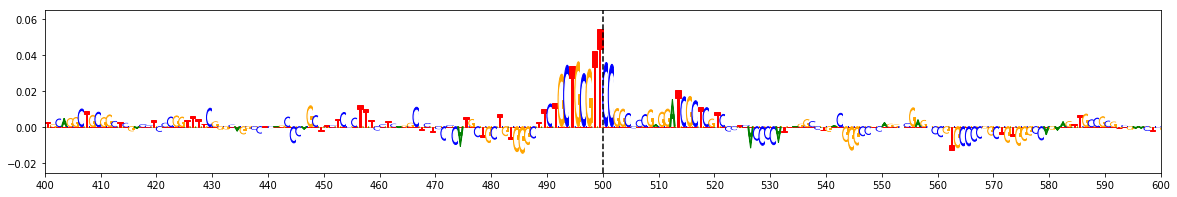

Noneffect Allele: C   ||  Explain Score: 0.2203   ||  Center / 200bp: 0.425
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


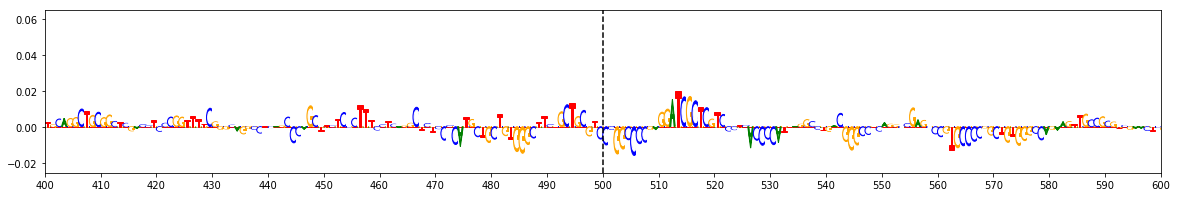

Allele Ratio : 2.7589   ||   Allele Difference : 0.483  ||  ISM Score : 0.7646  ||  deltaSVM Score : 4.4446


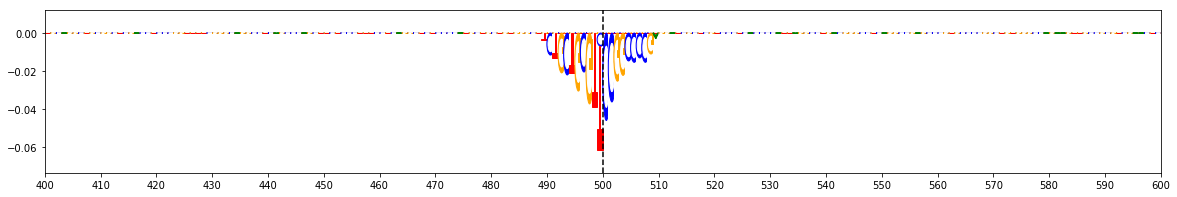


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62055499   ||    chr17 : 45876624 - 45876625   ||    Locus: 57   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.79E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.511   ||  Center / 200bp: 0.6157
Effect Sequence: TGTCATTCCGCTATGCCAGG


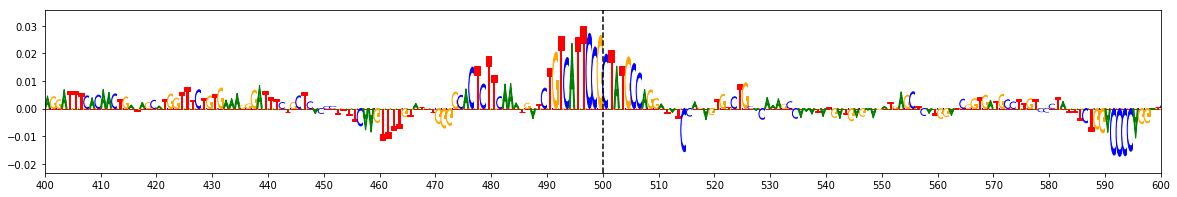

Noneffect Allele: C   ||  Explain Score: 0.2848   ||  Center / 200bp: 0.4718
Noneffect Sequence: TGTCATTCCCCTATGCCAGG


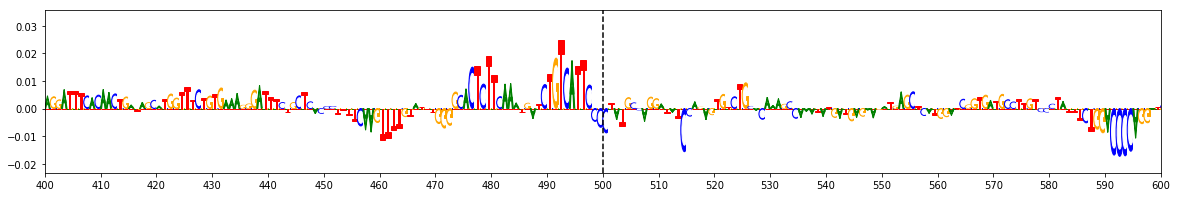

Allele Ratio : 1.7941   ||   Allele Difference : 0.262  ||  ISM Score : 0.4071  ||  deltaSVM Score : 2.3285


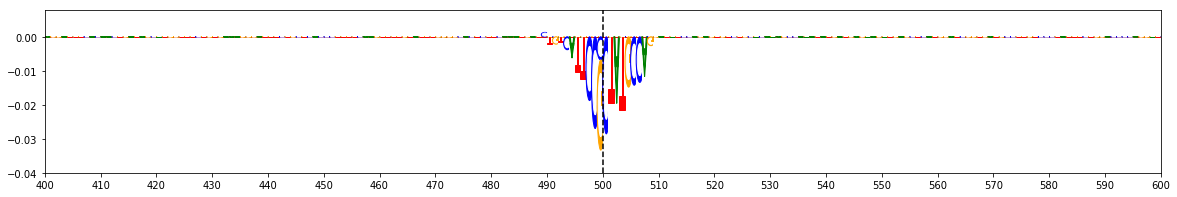


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79596632   ||    chr4 : 89723193 - 89723194   ||    Locus: 153   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.10E-12

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7064   ||  Center / 200bp: 0.5839
Effect Sequence: AAAGGAAACGCTGTTTTTCT


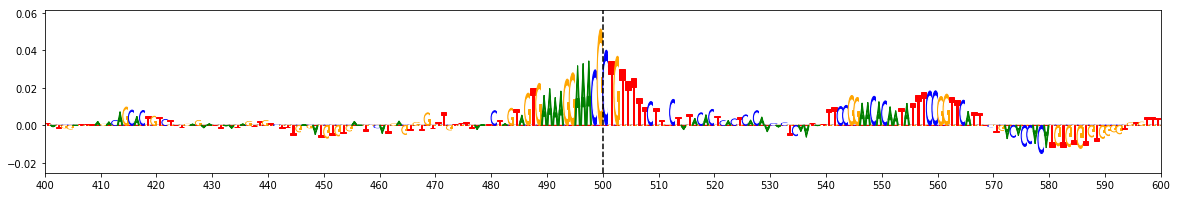

Noneffect Allele: A   ||  Explain Score: 0.4366   ||  Center / 200bp: 0.4661
Noneffect Sequence: AAAGGAAACACTGTTTTTCT


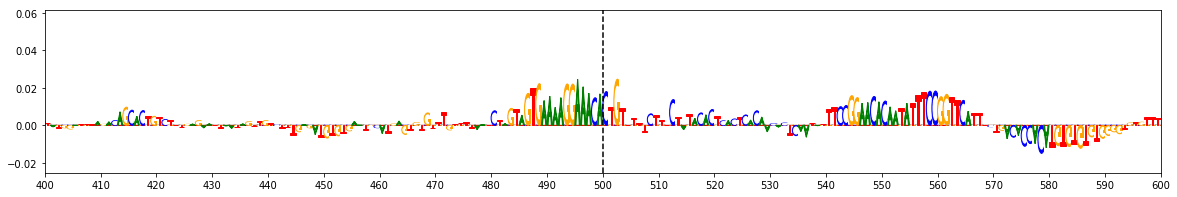

Allele Ratio : 1.6179   ||   Allele Difference : 0.2733  ||  ISM Score : 0.4374  ||  deltaSVM Score : 2.4764


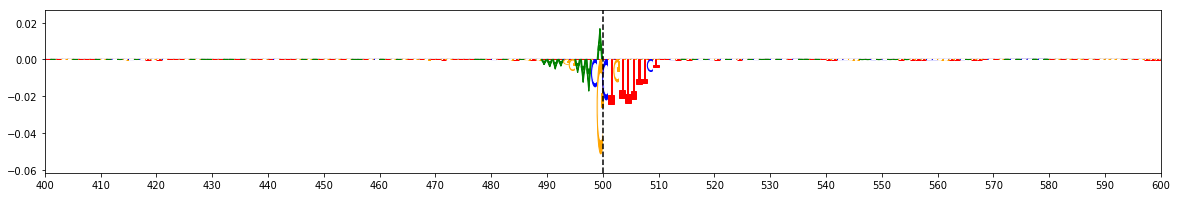


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11540084   ||    chr19 : 44644039 - 44644040   ||    Locus: 87   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  5.12E-08
Alzheimers_Jansen_2018 		  2.18E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.1832   ||  Center / 200bp: 0.6767
Effect Sequence: AGAGCGAGCTGGCGCCGGGA


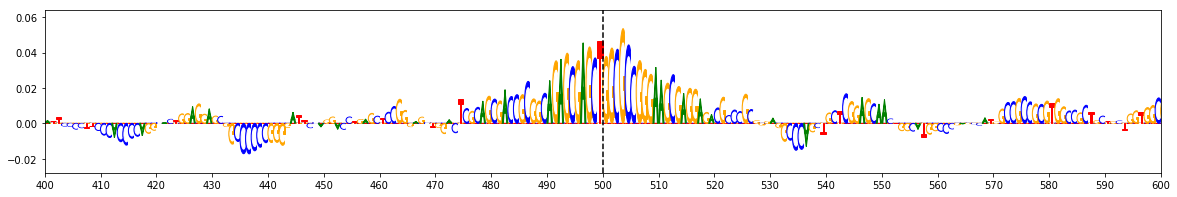

Noneffect Allele: G   ||  Explain Score: 0.967   ||  Center / 200bp: 0.6315
Noneffect Sequence: AGAGCGAGCGGGCGCCGGGA


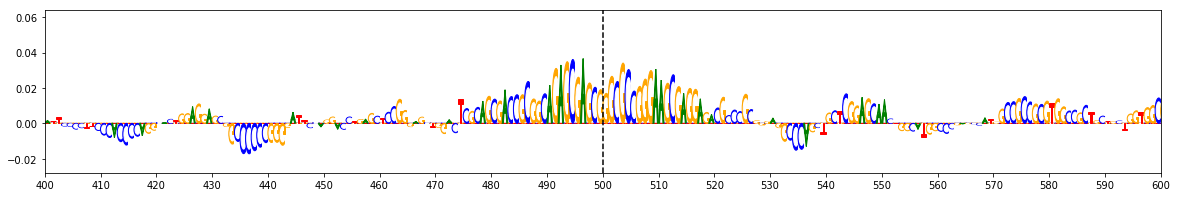

Allele Ratio : 1.2235   ||   Allele Difference : 0.2162  ||  ISM Score : 0.3413  ||  deltaSVM Score : 1.9441


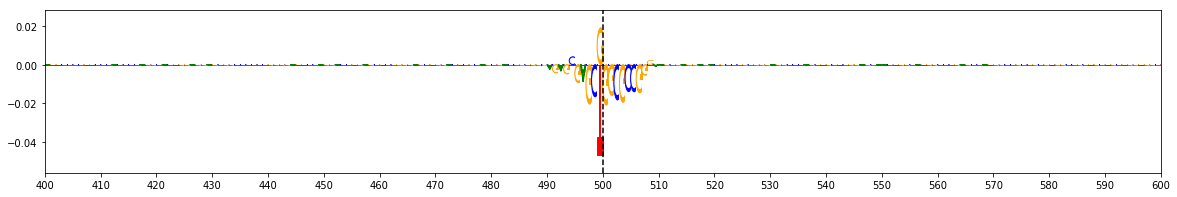


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2293578   ||    chr11 : 47415851 - 47415852   ||    Locus: 8   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.69E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3502   ||  Center / 200bp: 0.4049
Effect Sequence: TTTCCTGGCTCTTCCTTCCC


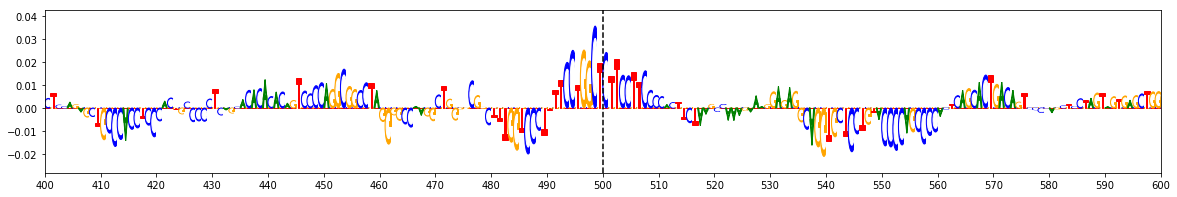

Noneffect Allele: C   ||  Explain Score: 0.1762   ||  Center / 200bp: 0.255
Noneffect Sequence: TTTCCTGGCCCTTCCTTCCC


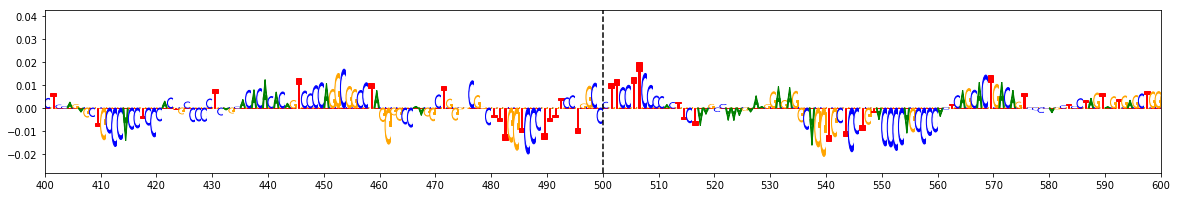

Allele Ratio : 1.9873   ||   Allele Difference : 0.2019  ||  ISM Score : 0.3197  ||  deltaSVM Score : 1.8527


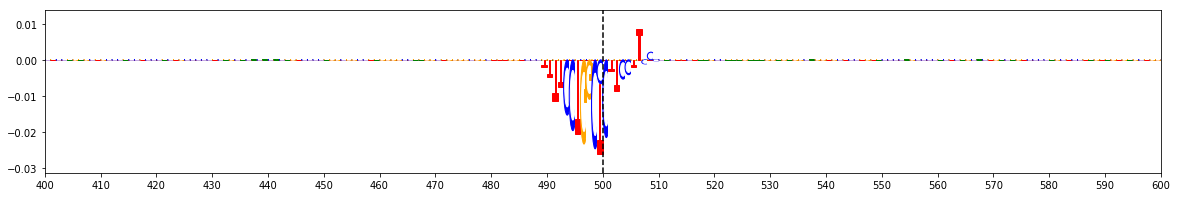


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1458202   ||    chr16 : 30941880 - 30941881   ||    Locus: 30   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.70E-05

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.462   ||  Center / 200bp: 0.5844
Effect Sequence: ATCATAAACGAGGCTTCTGA


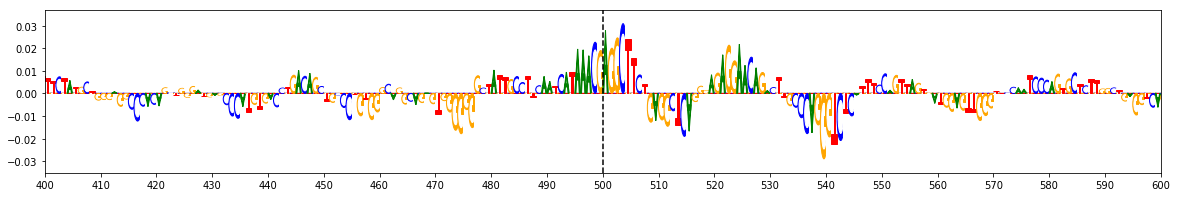

Noneffect Allele: A   ||  Explain Score: 0.3369   ||  Center / 200bp: 0.5063
Noneffect Sequence: ATCATAAACAAGGCTTCTGA


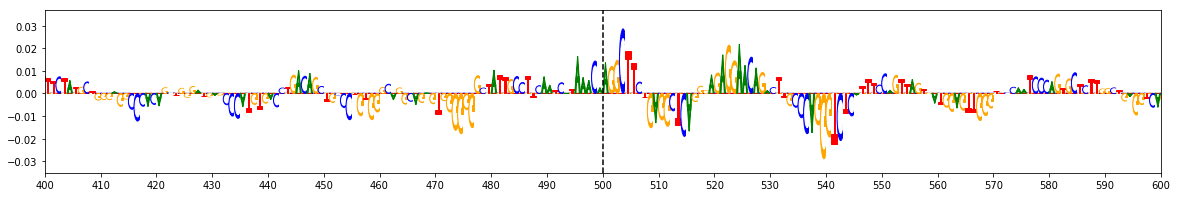

Allele Ratio : 1.3711   ||   Allele Difference : 0.1304  ||  ISM Score : 0.203  ||  deltaSVM Score : 1.185


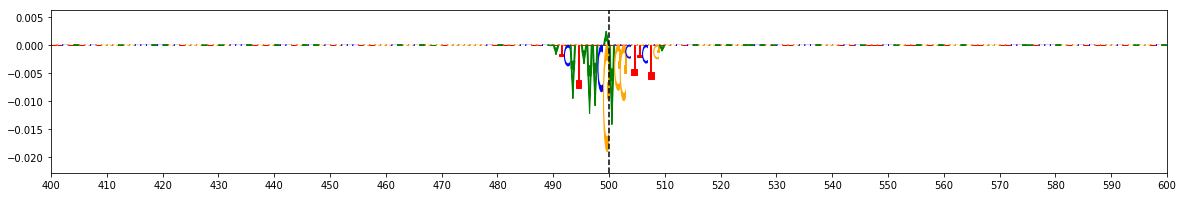


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74329237   ||    chr4 : 89723238 - 89723239   ||    Locus: 154   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.13E-12

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6801   ||  Center / 200bp: 0.5477
Effect Sequence: AATATTTCCGGAACACAATA


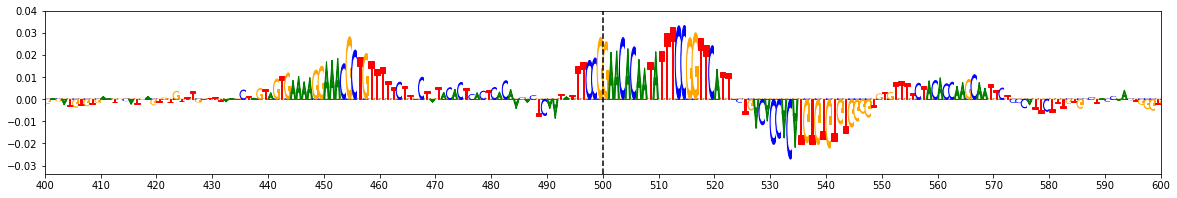

Noneffect Allele: A   ||  Explain Score: 0.4662   ||  Center / 200bp: 0.449
Noneffect Sequence: AATATTTCCAGAACACAATA


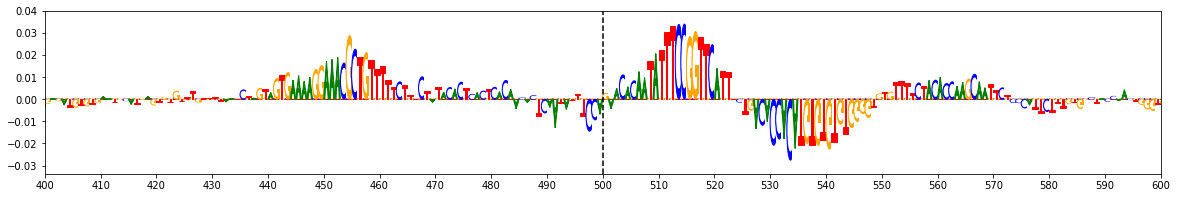

Allele Ratio : 1.4588   ||   Allele Difference : 0.2661  ||  ISM Score : 0.3883  ||  deltaSVM Score : 2.5253


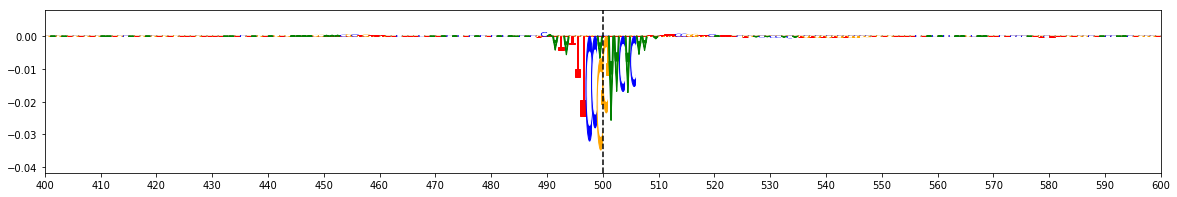


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113151753   ||    chr17 : 5282069 - 5282070   ||    Locus: 40   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  2.04E-08

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.5956   ||  Center / 200bp: 0.3981
Effect Sequence: TCAGGCGCCGAGCTCCGCCG


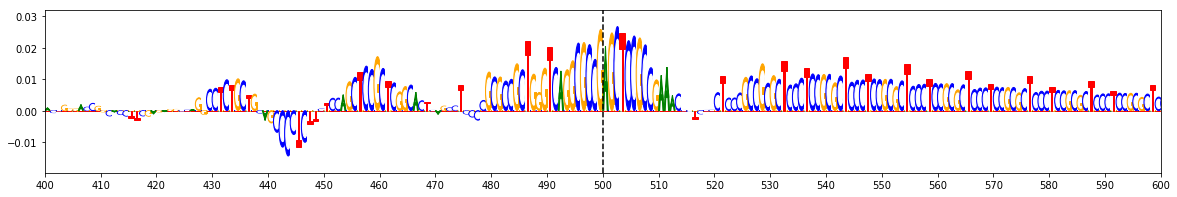

Noneffect Allele: C   ||  Explain Score: 0.3125   ||  Center / 200bp: 0.2575
Noneffect Sequence: TCAGGCGCCCAGCTCCGCCG


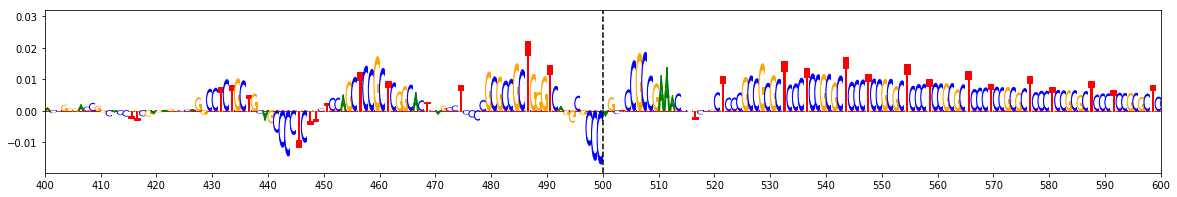

Allele Ratio : 1.9058   ||   Allele Difference : 0.3359  ||  ISM Score : 0.8324  ||  deltaSVM Score : 4.793


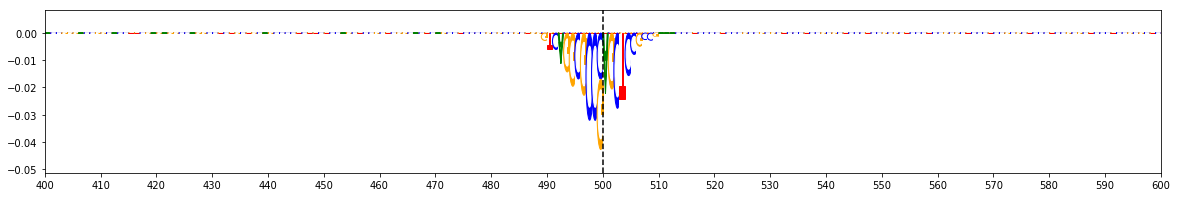


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054846   ||    chr17 : 45861267 - 45861268   ||    Locus: 54   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.32E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.0993   ||  Center / 200bp: 0.5315
Effect Sequence: AGGATGGCAGTTAGGAAGGG


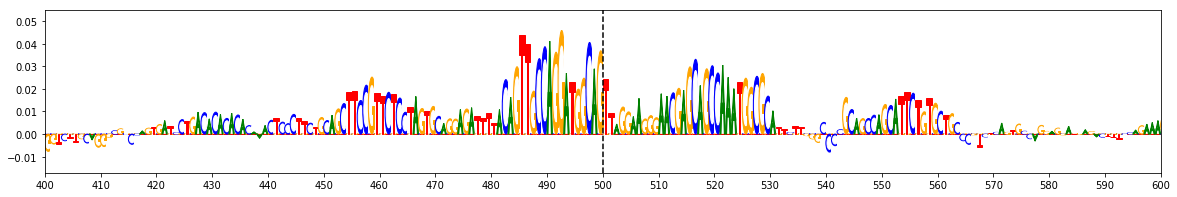

Noneffect Allele: A   ||  Explain Score: 0.7989   ||  Center / 200bp: 0.4519
Noneffect Sequence: AGGATGGCAATTAGGAAGGG


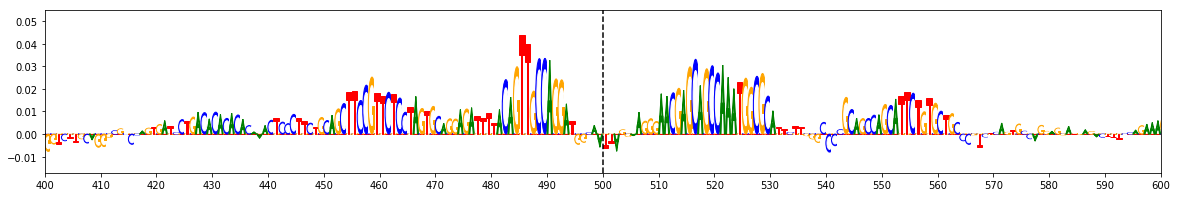

Allele Ratio : 1.3761   ||   Allele Difference : 0.3336  ||  ISM Score : 0.5225  ||  deltaSVM Score : 3.0268


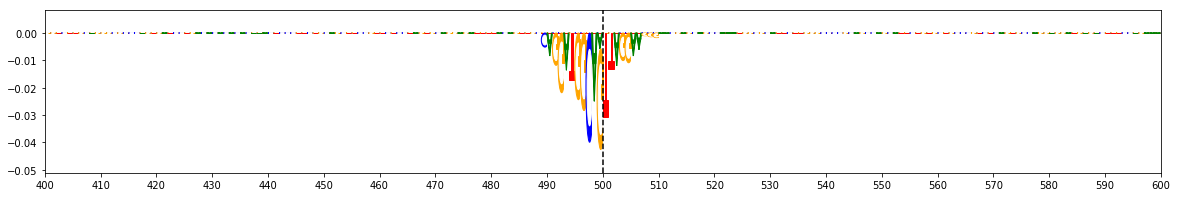


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs16896101   ||    chr4 : 17949002 - 17949003   ||    Locus: 147   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.44E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.447   ||  Center / 200bp: 0.3942
Effect Sequence: GGGTTTAACGGATATCTGGC


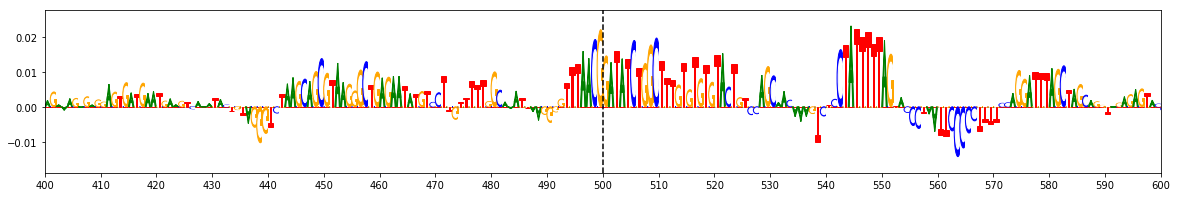

Noneffect Allele: A   ||  Explain Score: 0.2414   ||  Center / 200bp: 0.2608
Noneffect Sequence: GGGTTTAACAGATATCTGGC


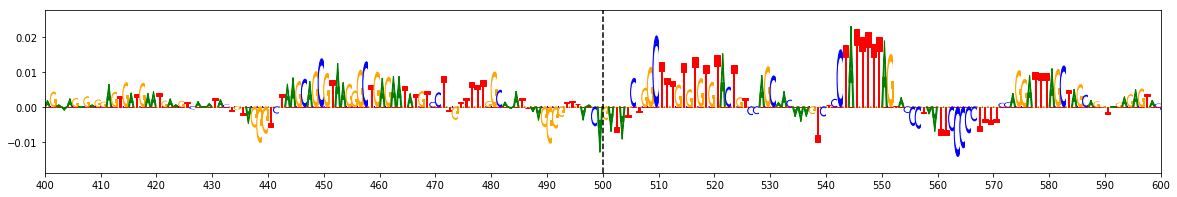

Allele Ratio : 1.8515   ||   Allele Difference : 0.2761  ||  ISM Score : 0.4326  ||  deltaSVM Score : 2.4805


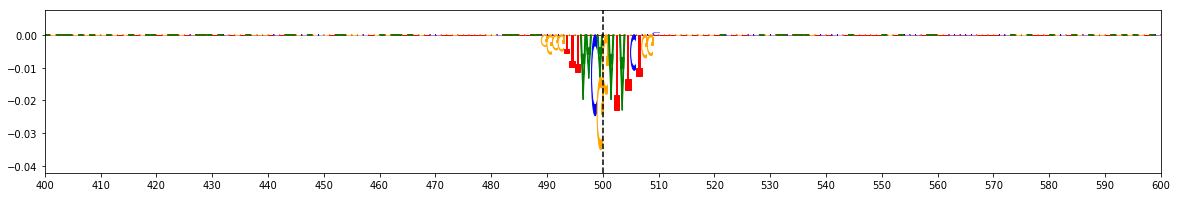


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8180209   ||    chr4 : 89723302 - 89723303   ||    Locus: 155   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.48E-18

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.521   ||  Center / 200bp: 0.4624
Effect Sequence: TTCTACACCGAGCAATTCTC


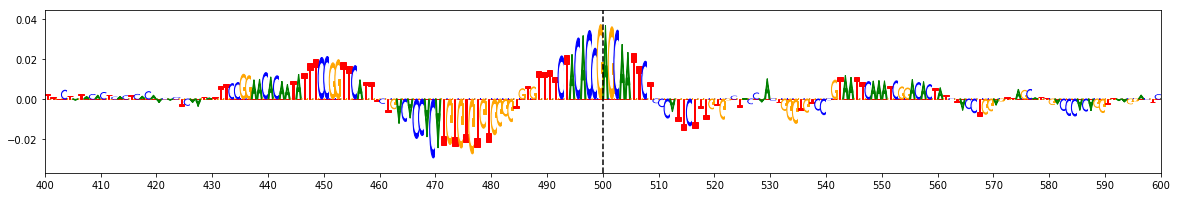

Noneffect Allele: A   ||  Explain Score: 0.3389   ||  Center / 200bp: 0.3588
Noneffect Sequence: TTCTACACCAAGCAATTCTC


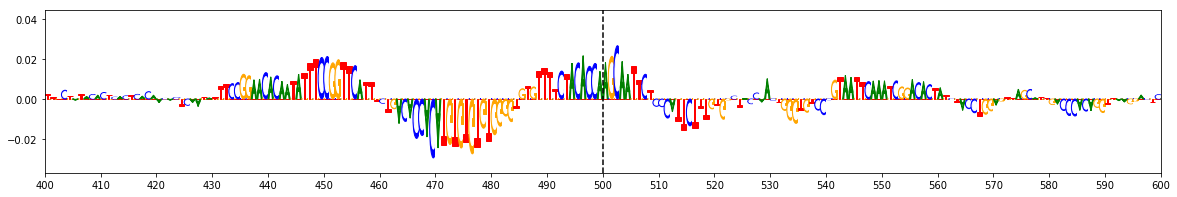

Allele Ratio : 1.5372   ||   Allele Difference : 0.1838  ||  ISM Score : 0.2897  ||  deltaSVM Score : 1.6824


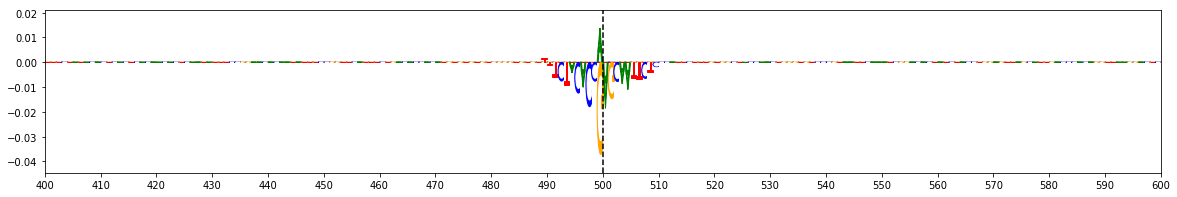


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 14   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9445   ||  Center / 200bp: 0.5353
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


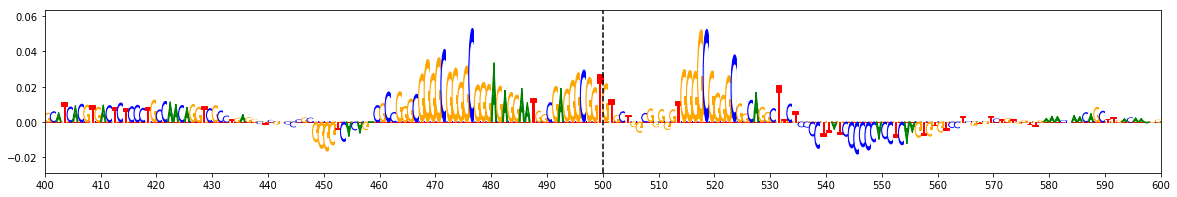

Noneffect Allele: C   ||  Explain Score: 0.712   ||  Center / 200bp: 0.4652
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


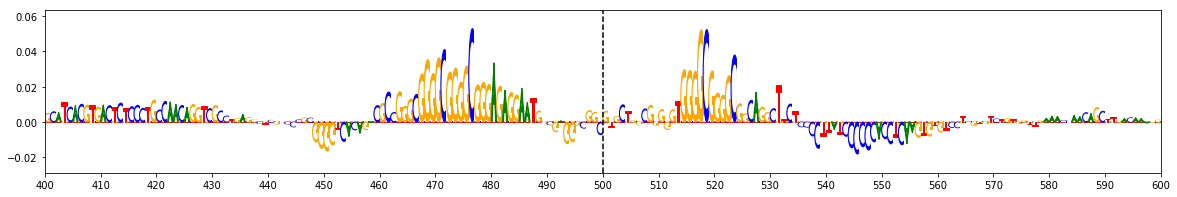

Allele Ratio : 1.3265   ||   Allele Difference : 0.2707  ||  ISM Score : 0.4505  ||  deltaSVM Score : 2.7023


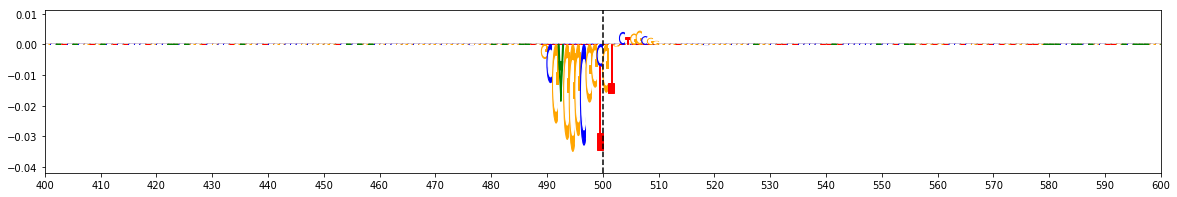


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1859787   ||    chr7 : 100226729 - 100226730   ||    Locus: 182   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.56E-08

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7242   ||  Center / 200bp: 0.3645
Effect Sequence: ATCAAAGCCGCAGGCTTCGG


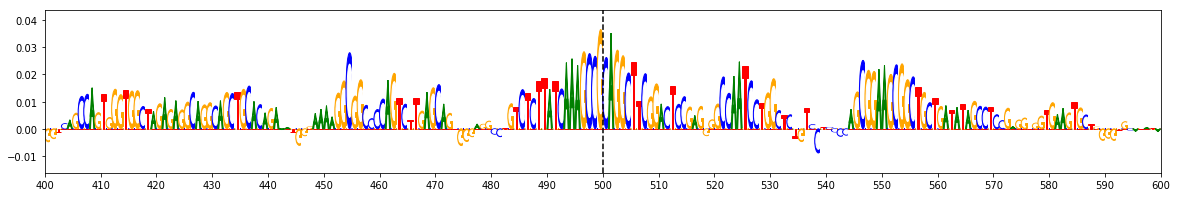

Noneffect Allele: A   ||  Explain Score: 0.394   ||  Center / 200bp: 0.238
Noneffect Sequence: ATCAAAGCCACAGGCTTCGG


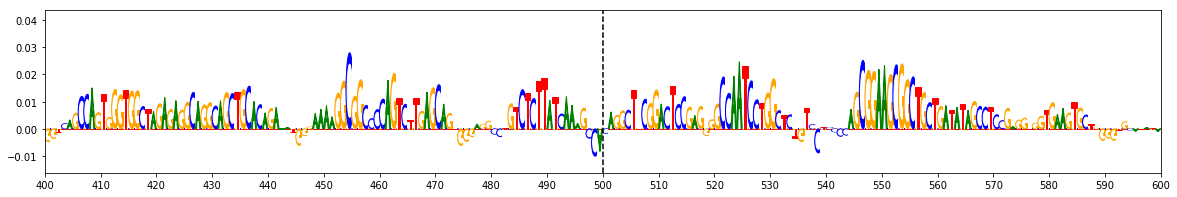

Allele Ratio : 1.8381   ||   Allele Difference : 0.3538  ||  ISM Score : 0.5552  ||  deltaSVM Score : 3.2095


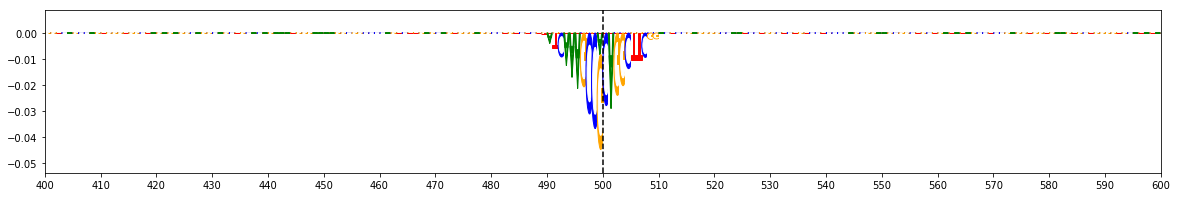


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3105101   ||    chr2 : 95076932 - 95076933   ||    Locus: 107   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.57E-02

Coloc:  False

Effect Allele: C   ||  Explain Score: 1.843   ||  Center / 200bp: 0.6104
Effect Sequence: AGCAAACACCGAGTGGTGCT


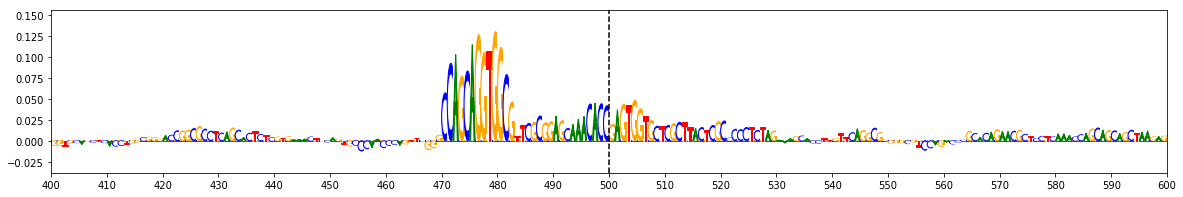

Noneffect Allele: A   ||  Explain Score: 1.68   ||  Center / 200bp: 0.5881
Noneffect Sequence: AGCAAACACAGAGTGGTGCT


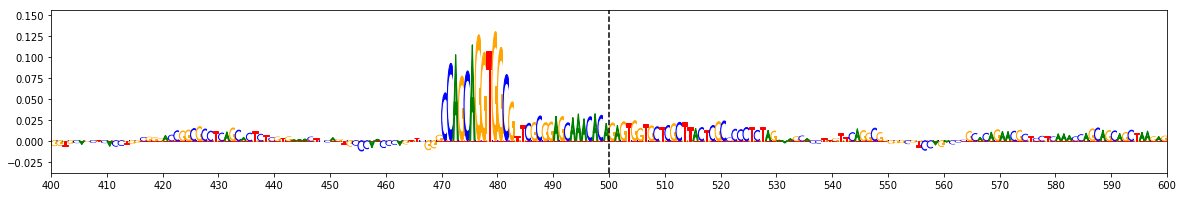

Allele Ratio : 1.097   ||   Allele Difference : 0.163  ||  ISM Score : 0.2534  ||  deltaSVM Score : 1.4104


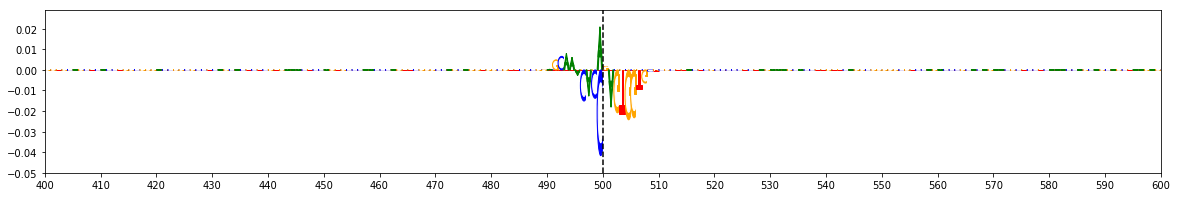


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064662   ||    chr17 : 46002354 - 46002355   ||    Locus: 66   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.18E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.5907   ||  Center / 200bp: 0.5012
Effect Sequence: TAGAGGAGAGCTGAAGAAGC


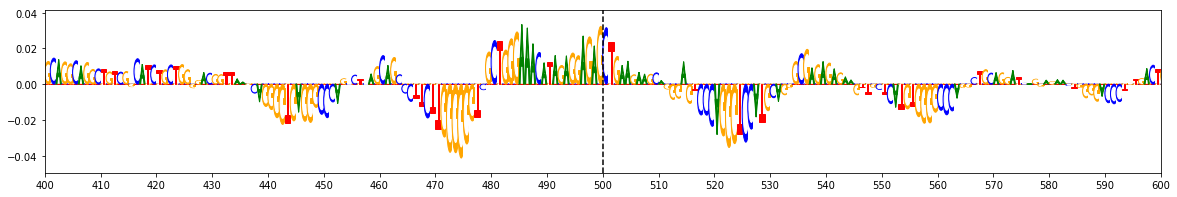

Noneffect Allele: A   ||  Explain Score: 0.4494   ||  Center / 200bp: 0.4332
Noneffect Sequence: TAGAGGAGAACTGAAGAAGC


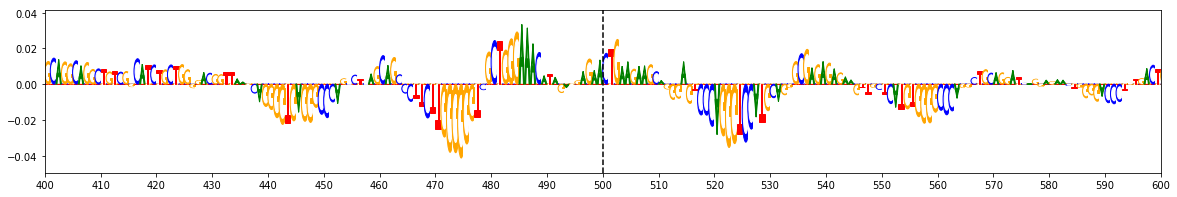

Allele Ratio : 1.3144   ||   Allele Difference : 0.148  ||  ISM Score : 0.234  ||  deltaSVM Score : 1.3861


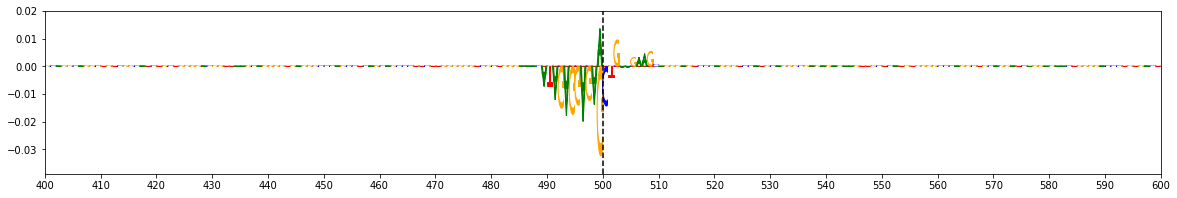


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs149814394   ||    chr3 : 52339932 - 52339933   ||    Locus: 137   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.38E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.2578   ||  Center / 200bp: 0.4
Effect Sequence: TATCCTCCAGTCTACAAATG


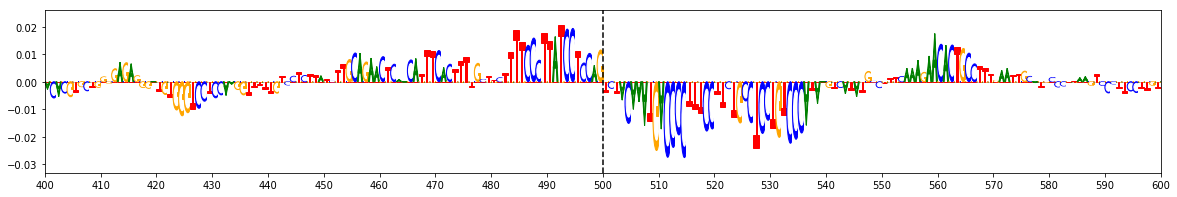

Noneffect Allele: A   ||  Explain Score: 0.1572   ||  Center / 200bp: 0.2891
Noneffect Sequence: TATCCTCCAATCTACAAATG


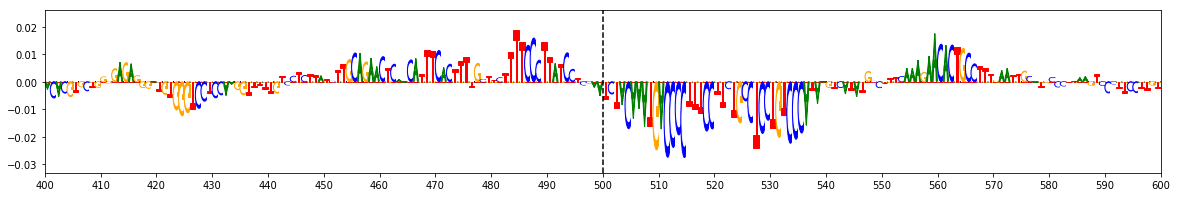

Allele Ratio : 1.6395   ||   Allele Difference : 0.1305  ||  ISM Score : 0.2169  ||  deltaSVM Score : 1.2788


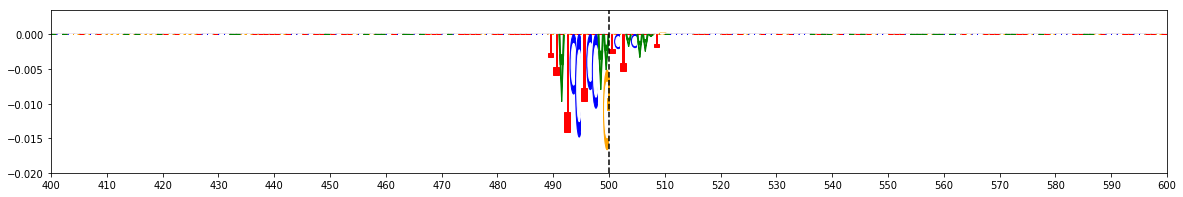


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 125   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5859   ||  Center / 200bp: 0.4396
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


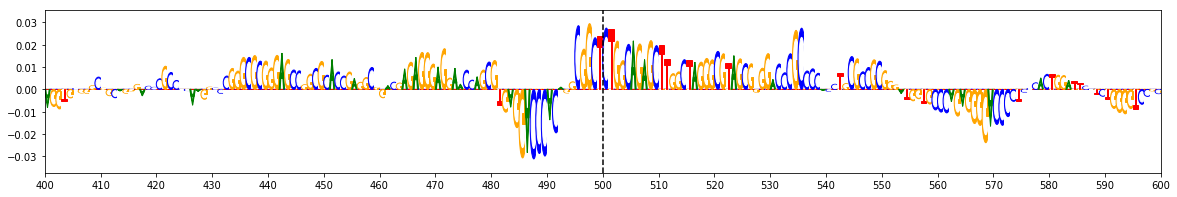

Noneffect Allele: C   ||  Explain Score: 0.394   ||  Center / 200bp: 0.3442
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


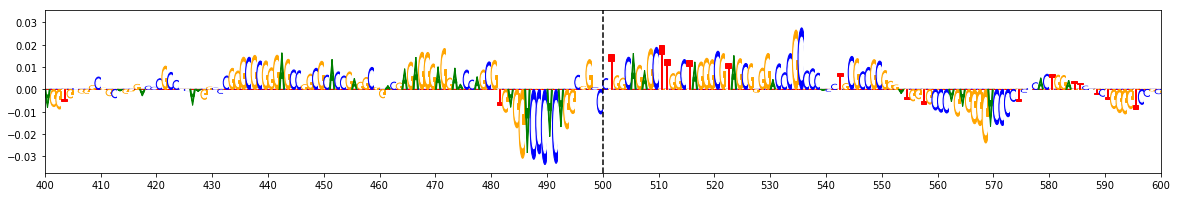

Allele Ratio : 1.4868   ||   Allele Difference : 0.2723  ||  ISM Score : 0.4359  ||  deltaSVM Score : 2.563


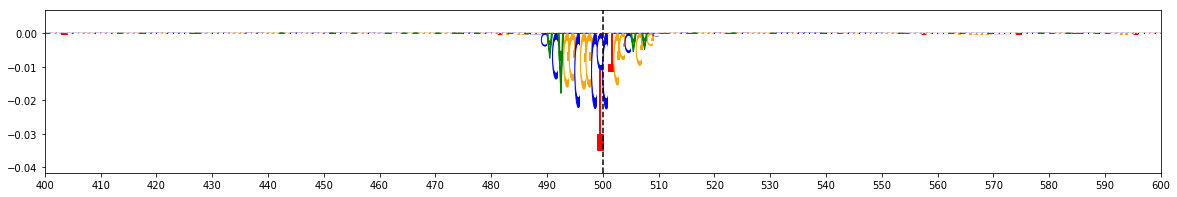


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 145   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.4942   ||  Center / 200bp: 0.4638
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


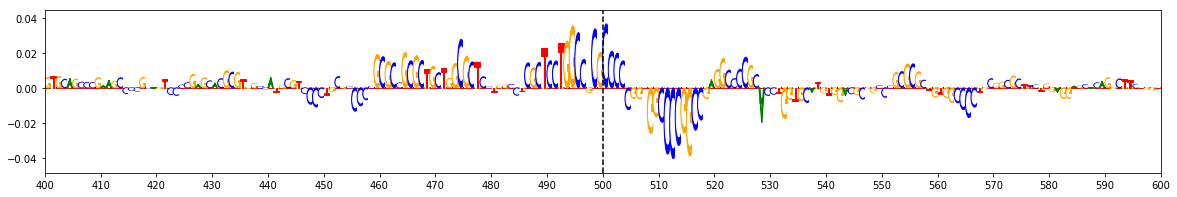

Noneffect Allele: A   ||  Explain Score: 0.3645   ||  Center / 200bp: 0.3858
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


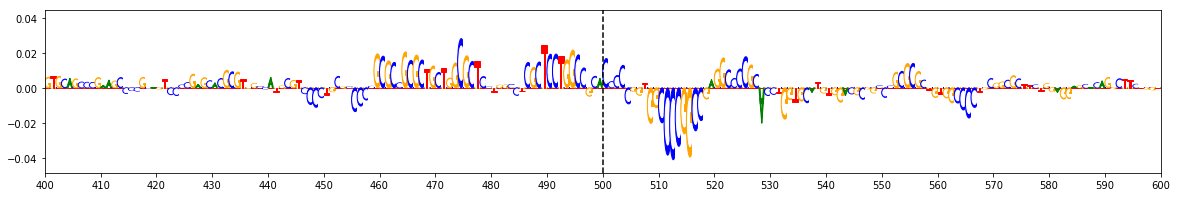

Allele Ratio : 1.3559   ||   Allele Difference : 0.1148  ||  ISM Score : 0.1928  ||  deltaSVM Score : 1.125


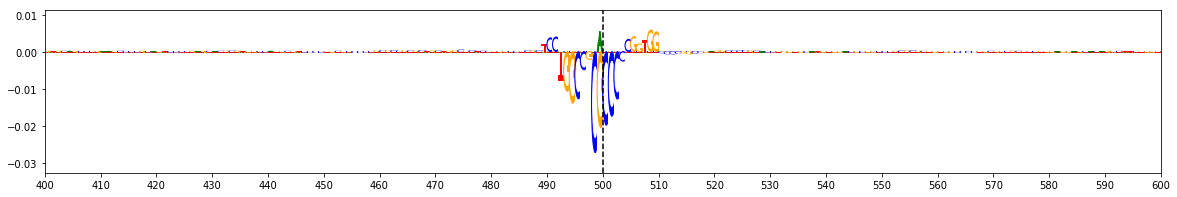


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8050894   ||    chr16 : 31093187 - 31093188   ||    Locus: 34   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  8.01E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7885   ||  Center / 200bp: 0.5886
Effect Sequence: AGGACGCTCGGTGATGAGCA


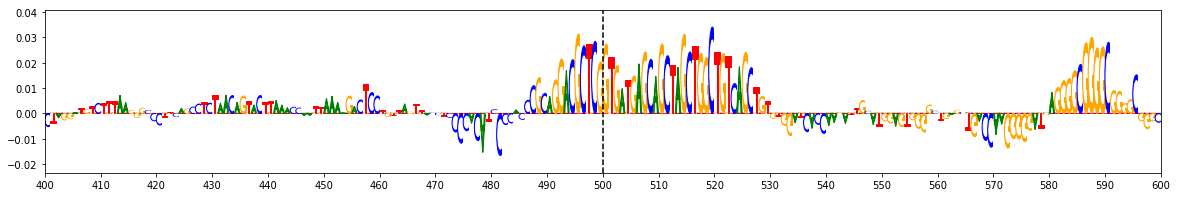

Noneffect Allele: C   ||  Explain Score: 0.7537   ||  Center / 200bp: 0.5776
Noneffect Sequence: AGGACGCTCCGTGATGAGCA


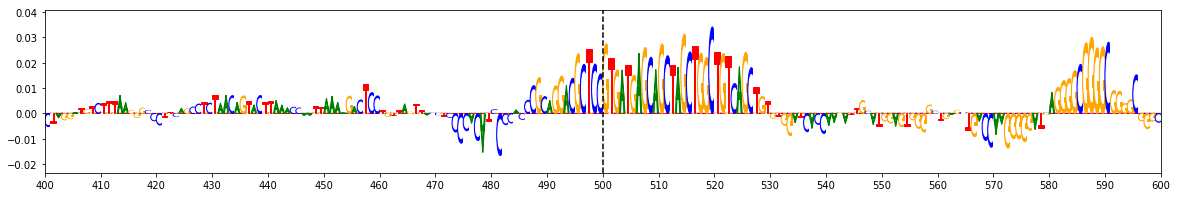

Allele Ratio : 1.0461   ||   Allele Difference : 0.0348  ||  ISM Score : 0.055  ||  deltaSVM Score : 0.3324


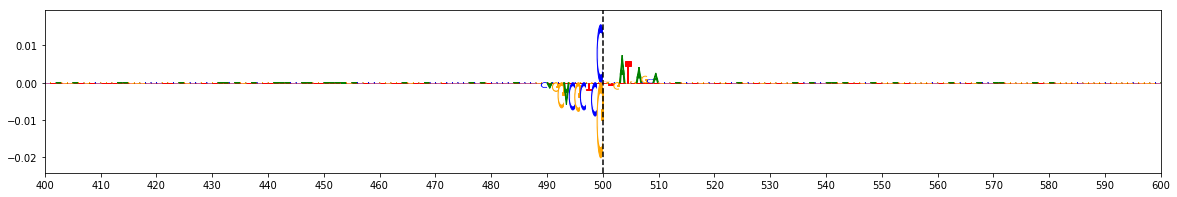


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150820726   ||    chr19 : 44723890 - 44723891   ||    Locus: 88   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.02E-11

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3655   ||  Center / 200bp: 0.4509
Effect Sequence: AGCTGCCACTTGCAGGGTGA


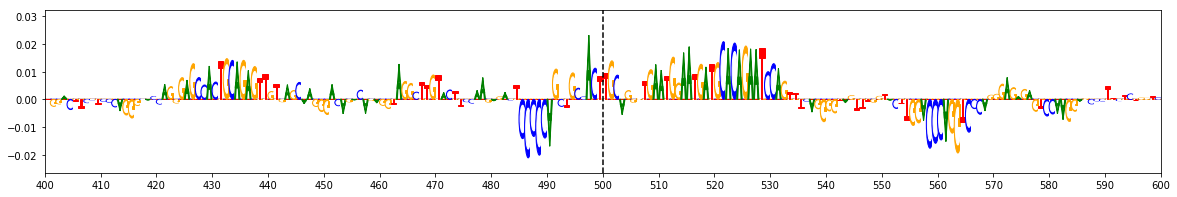

Noneffect Allele: A   ||  Explain Score: 0.285   ||  Center / 200bp: 0.39
Noneffect Sequence: AGCTGCCACATGCAGGGTGA


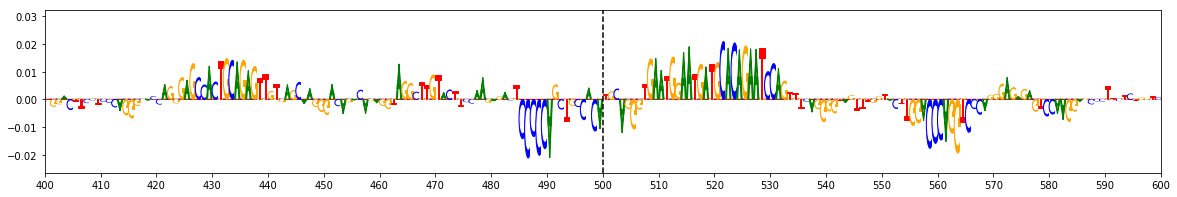

Allele Ratio : 1.2821   ||   Allele Difference : 0.1521  ||  ISM Score : 0.2385  ||  deltaSVM Score : 1.3653


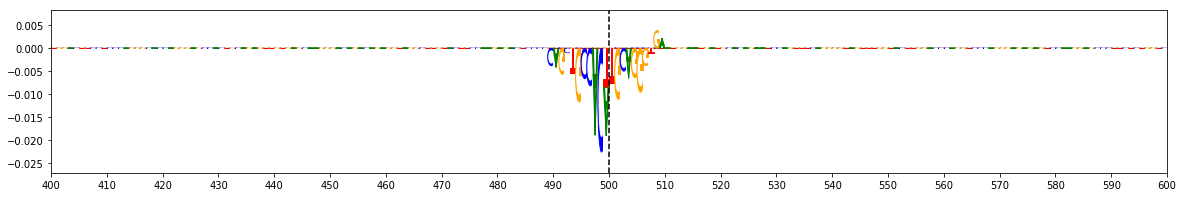


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()